In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folders that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]

# The folder for training files
data_directory = '/full/path/to/training/data/directory'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names

# The folder for saving training checkpoints
training_records_dir = '/full/path/to/training/records/directory'

# The folder for test and unlabeled data
test_data_directory = '/full/path/to/test/data/directory'

# The folder for new \ test data labeling results 
results_dir = '/full/path/to/results/directory'
results_file = 'Results_File_Name'


# Parameters
input_vec_size = 513 
batch_size = 11
n_syllables = 53 #44 #including zero
learning_rate = 0.001
n_max_iter = 18001
time_steps = 87 #370


data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
print "There are ", number_of_files, " entries for training." 

There are  1074  entries for training.


In [2]:
n_lstm_layers = 2
window_time_steps = 11

In [3]:
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    #First convolutional layers
     # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=tf.reshape(spectrogram,[batch_size,-1,input_vec_size,1]), #time_steps
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=[1,8])
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 8], strides=[1,8])
    # Second the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'):
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(lstm_f1,lstm_b1, tf.reshape(pool2,[batch_size,-1,512]), time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Third, projection on the number of syllables creates logits    time_steps
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy')
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
        # Generate placeholders for the spectrograms and labels.
        X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms batch_size,time_steps
        Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels batch_size
        lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
        tf.add_to_collection("specs", X)  # Remember this Op.
        tf.add_to_collection("labels", Y)  # Remember this Op.
        tf.add_to_collection("lng", lng)  # Remember this Op.
        # Build a Graph that computes predictions from the inference model.
        logits,outputs = label_inference_graph(X, 512, n_lstm_layers, lng) #lstm_size
        tf.add_to_collection("logits", logits)  # Remember this Op.

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op, cost = training_graph(logits, Y, learning_rate, lng)

        # Add the variable initializer Op.
        init = tf.global_variables_initializer() #initialize_all_variables()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver(max_to_keep = 10)

In [11]:
# Prepare training dataset. All training data is loaded to memory
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
    
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

0
(2292,)
1
(2759,)
2
(5636,)
3
(6655,)
4
(8088,)
5
(8916,)
6
(9601,)
7
(11277,)
8
(12798,)
9
(13408,)
10
(14044,)
11
(14820,)
12
(15669,)
13
(18279,)
14
(18854,)
15
(19524,)
16
(20235,)
17
(20886,)
18
(21607,)
19
(22166,)
20
(22599,)
21
(23721,)
22
(24317,)
23
(25399,)
24
(26970,)
25
(30583,)
26
(32431,)
27
(33430,)
28
(34383,)
29
(35350,)
30
(36391,)
31
(37339,)
32
(38623,)
33
(41281,)
34
(42105,)
35
(44415,)
36
(48158,)
37
(49716,)
38
(52645,)
39
(53261,)
40
(54255,)
41
(55906,)
42
(57699,)
43
(60538,)
44
(61999,)
45
(64890,)
46
(65784,)
47
(66498,)
48
(67141,)
49
(67695,)
50
(68429,)
51
(69063,)
52
(70386,)
53
(71914,)
54
(73829,)
55
(74567,)
56
(75925,)
57
(76695,)
58
(77402,)
59
(78106,)
60
(79262,)
61
(79959,)
62
(80731,)
63
(81648,)
64
(82947,)
65
(84003,)
66
(84633,)
67
(85225,)
68
(87096,)
69
(87717,)
70
(88463,)
71
(89023,)
72
(89609,)
73
(90197,)
74
(90684,)
75
(91054,)
76
(91613,)
77
(92263,)
78
(92997,)
79
(94313,)
80
(97346,)
81
(99272,)
82
(101134,)
83
(101913,)
84
(102

(647768,)
601
(648547,)
602
(649262,)
603
(649881,)
604
(650622,)
605
(651465,)
606
(652079,)
607
(652622,)
608
(653515,)
609
(655077,)
610
(657972,)
611
(658842,)
612
(661537,)
613
(663995,)
614
(665389,)
615
(666756,)
616
(668018,)
617
(668564,)
618
(669302,)
619
(669828,)
620
(670278,)
621
(670871,)
622
(671803,)
623
(672449,)
624
(673883,)
625
(674429,)
626
(675916,)
627
(676843,)
628
(677716,)
629
(678641,)
630
(679579,)
631
(680234,)
632
(681197,)
633
(681841,)
634
(682870,)
635
(684724,)
636
(685340,)
637
(685847,)
638
(686359,)
639
(687762,)
640
(689065,)
641
(691245,)
642
(692002,)
643
(692770,)
644
(693424,)
645
(694139,)
646
(695172,)
647
(695774,)
648
(696859,)
649
(700235,)
650
(701748,)
651
(702535,)
652
(703235,)
653
(706240,)
654
(707482,)
655
(708857,)
656
(709997,)
657
(710474,)
658
(711356,)
659
(712133,)
660
(712807,)
661
(713515,)
662
(714371,)
663
(715353,)
664
(715839,)
665
(716508,)
666
(719186,)
667
(720400,)
668
(721368,)
669
(721926,)
670
(722599,)
671
(72348

In [18]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

[1, 95395, 5.4946113]
[2, 22234, 2.3155296]
[3, 65916, 1.9096938]
[4, 67514, 2.6002665]
[5, 20737, 1.7184311]
[6, 43438, 1.4587606]
[7, 41979, 1.507954]
[8, 65957, 1.9765524]
[9, 38708, 1.6005142]
[10, 95357, 0.51840353]
[11, 23612, 1.1777537]
[12, 2869, 0.83329242]
[13, 79916, 0.64448243]
[14, 84239, 1.6005651]
[15, 5634, 1.8902128]
[16, 79618, 2.1786952]
[17, 95769, 1.9486743]
[18, 56605, 1.6595935]
[19, 900, 1.2947954]
[20, 72325, 0.96352845]
[21, 46421, 0.62071544]
[22, 94770, 1.3732013]
[23, 88083, 1.8600463]
[24, 94626, 1.6023461]
[25, 83677, 1.0628098]
[26, 87289, 0.69232833]
[27, 53382, 0.57619816]
[28, 70634, 1.1790905]
[29, 24453, 0.75681603]
[30, 97539, 0.79083043]
[31, 56754, 0.89974421]
[32, 366, 1.100741]
[33, 12932, 0.82552719]
[34, 71851, 0.83874291]
[35, 2039, 0.9626503]
[36, 57726, 0.79179037]
[37, 47013, 0.57425046]
[38, 55129, 0.91319674]
[39, 96818, 1.0754424]
[40, 53173, 0.58460379]
[41, 86989, 0.85586971]
[42, 22232, 0.72553837]
[43, 59822, 1.0749258]
[44, 41545,

[336, 63388, 0.3441537]
[337, 44100, 0.2626729]
[338, 63533, 0.52614444]
[339, 60137, 0.3673034]
[340, 56569, 0.27676308]
[341, 95402, 0.13221437]
[342, 31680, 0.17250751]
[343, 45040, 0.13323809]
[344, 71464, 0.49696651]
[345, 28398, 0.12869504]
[346, 72060, 0.32486889]
[347, 89700, 0.60016805]
[348, 37709, 0.2776351]
[349, 86210, 0.53340238]
[350, 47360, 0.10463224]
[351, 67725, 0.12282969]
[352, 69620, 0.13720004]
[353, 76351, 0.11931125]
[354, 8462, 0.22753115]
[355, 65257, 0.5109598]
[356, 42684, 0.15017819]
[357, 55410, 0.23177063]
[358, 94402, 0.50441158]
[359, 89695, 0.56151968]
[360, 1317, 0.40993094]
[361, 10571, 0.097632885]
[362, 86811, 0.23354438]
[363, 91284, 0.87847805]
[364, 76125, 0.81005657]
[365, 60549, 0.36543757]
[366, 11940, 0.20350887]
[367, 97529, 0.19737673]
[368, 65560, 0.35877967]
[369, 29576, 0.38777125]
[370, 99414, 0.48780742]
[371, 18359, 0.20430128]
[372, 6233, 0.13180001]
[373, 25795, 0.24039522]
[374, 4072, 0.48172361]
[375, 53966, 0.30664185]
[376, 51

[665, 24218, 0.20145258]
[666, 91386, 0.83565164]
[667, 50657, 0.23684081]
[668, 22665, 0.14961025]
[669, 25634, 0.33113128]
[670, 20156, 0.17264722]
[671, 85587, 0.73158365]
[672, 65724, 0.6063022]
[673, 21756, 0.26788628]
[674, 62791, 0.2901459]
[675, 49919, 0.13359001]
[676, 86503, 0.68608195]
[677, 17047, 0.094584949]
[678, 80524, 0.18543898]
[679, 75110, 0.30473909]
[680, 79226, 0.2254155]
[681, 98524, 0.17345008]
[682, 78574, 0.4197377]
[683, 48268, 0.044851411]
[684, 37722, 0.14086597]
[685, 60710, 0.15182646]
[686, 79034, 0.46626803]
[687, 84022, 0.12345299]
[688, 12521, 0.091008663]
[689, 83645, 0.069458283]
[690, 99921, 0.58078057]
[691, 20663, 0.1077733]
[692, 87285, 0.47932896]
[693, 18910, 0.11293963]
[694, 82218, 0.1303948]
[695, 23892, 0.18351407]
[696, 27580, 0.12434284]
[697, 51335, 0.12567654]
[698, 82081, 0.36704937]
[699, 67703, 0.023122154]
0.245756
[700, 32896, 0.25183684]
[701, 45384, 0.19584891]
[702, 7869, 0.11287021]
[703, 37512, 0.089536883]
[704, 93200, 0.02

[992, 5862, 0.029709885]
[993, 42147, 0.099459156]
[994, 75739, 0.11065412]
[995, 41233, 0.10233214]
[996, 21939, 0.12184652]
[997, 4260, 0.65277046]
[998, 28748, 0.23920883]
[999, 52308, 0.23965536]
0.195825
[1000, 24504, 0.038534168]
[1001, 71583, 0.70365286]
[1002, 73278, 0.18924513]
[1003, 90631, 0.17860472]
[1004, 70692, 0.44380212]
[1005, 81514, 0.54498965]
[1006, 48708, 0.27251244]
[1007, 18714, 0.046087332]
[1008, 19478, 0.21593693]
[1009, 74297, 0.54425263]
[1010, 68280, 0.097447231]
[1011, 2059, 0.081749916]
[1012, 99243, 0.15448748]
[1013, 55198, 0.069884703]
[1014, 19860, 0.13827774]
[1015, 89401, 0.40059501]
[1016, 71132, 0.054940987]
[1017, 17929, 0.068633147]
[1018, 21230, 0.17760542]
[1019, 41480, 0.016926771]
[1020, 60134, 0.18203412]
[1021, 64627, 0.082725659]
[1022, 83248, 0.31612933]
[1023, 9243, 0.1924758]
[1024, 91023, 0.17509393]
[1025, 36629, 0.13177073]
[1026, 7689, 0.35871401]
[1027, 80602, 0.057149988]
[1028, 80, 0.26243231]
[1029, 24789, 0.22183794]
[1030, 3

[1307, 59321, 0.081393614]
[1308, 72743, 0.47822747]
[1309, 29246, 0.037729245]
[1310, 36499, 0.18155894]
[1311, 56607, 0.20042938]
[1312, 51211, 0.15742958]
[1313, 68845, 0.64724666]
[1314, 38241, 0.21553816]
[1315, 30788, 0.43478]
[1316, 35733, 0.18330544]
[1317, 51761, 0.22624515]
[1318, 80281, 0.52485365]
[1319, 50681, 0.17261274]
[1320, 29432, 0.17519858]
[1321, 49712, 0.1291364]
[1322, 70205, 0.70163077]
[1323, 42612, 0.073347338]
[1324, 89664, 0.49570268]
[1325, 76456, 0.382806]
[1326, 13533, 0.089043543]
[1327, 66114, 0.17231308]
[1328, 59281, 0.088634461]
[1329, 88775, 0.4038035]
[1330, 90726, 0.37555769]
[1331, 59382, 0.11194842]
[1332, 97330, 0.57438266]
[1333, 19118, 0.10318346]
[1334, 82334, 0.15251119]
[1335, 7947, 0.12190762]
[1336, 7970, 0.16021001]
[1337, 55692, 0.3411943]
[1338, 4878, 0.14597818]
[1339, 64030, 0.14168198]
[1340, 22983, 0.051089559]
[1341, 35610, 0.17839307]
[1342, 92559, 0.36266479]
[1343, 57705, 0.12190478]
[1344, 41703, 0.13503377]
[1345, 98792, 0.5

[1621, 58337, 0.06865029]
[1622, 93652, 0.23910996]
[1623, 62555, 0.29746574]
[1624, 69874, 0.11627422]
[1625, 66078, 0.20109968]
[1626, 26244, 0.10231157]
[1627, 97607, 0.097720005]
[1628, 63562, 0.52117389]
[1629, 80583, 0.066335678]
[1630, 87495, 0.57009846]
[1631, 965, 0.098568492]
[1632, 80985, 0.38741878]
[1633, 14418, 0.18981944]
[1634, 52532, 0.091525249]
[1635, 28429, 0.10445374]
[1636, 40101, 0.21142405]
[1637, 86245, 0.47493446]
[1638, 282, 0.15150374]
[1639, 82982, 0.040490769]
[1640, 43381, 0.21045622]
[1641, 7915, 0.10567603]
[1642, 65964, 0.23027888]
[1643, 93528, 0.20966345]
[1644, 59553, 0.13930224]
[1645, 95822, 0.62107027]
[1646, 63518, 0.39803502]
[1647, 34778, 0.18361726]
[1648, 87768, 0.21325274]
[1649, 69302, 0.68783623]
[1650, 55630, 0.19114003]
[1651, 11491, 0.10097905]
[1652, 19081, 0.098696247]
[1653, 80609, 0.031871241]
[1654, 17237, 0.18529393]
[1655, 15464, 0.11868775]
[1656, 80722, 0.079704069]
[1657, 30277, 0.10969409]
[1658, 66838, 0.66499054]
[1659, 54

[1935, 7347, 0.11114423]
[1936, 77350, 0.070741348]
[1937, 53122, 0.11702817]
[1938, 60341, 0.19713104]
[1939, 50338, 0.061833508]
[1940, 9014, 0.18381359]
[1941, 52791, 0.075450152]
[1942, 42434, 0.19191238]
[1943, 52715, 0.039206222]
[1944, 12471, 0.058776245]
[1945, 14853, 0.10161868]
[1946, 28916, 0.17834942]
[1947, 7077, 0.039765283]
[1948, 78107, 0.092976145]
[1949, 12687, 0.077981323]
[1950, 67388, 0.48938352]
[1951, 63389, 0.29306415]
[1952, 57276, 0.24767734]
[1953, 50203, 0.088688448]
[1954, 94013, 0.36763149]
[1955, 61850, 0.1547004]
[1956, 27655, 0.20703948]
[1957, 92103, 0.79566139]
[1958, 20513, 0.12854442]
[1959, 88257, 0.80352241]
[1960, 56862, 0.13135596]
[1961, 40240, 0.10100909]
[1962, 53844, 0.29908392]
[1963, 66786, 0.67954963]
[1964, 93308, 0.35565743]
[1965, 52370, 0.25612155]
[1966, 16853, 0.077564135]
[1967, 16911, 0.090204313]
[1968, 54085, 0.045064673]
[1969, 34566, 0.27038348]
[1970, 66445, 0.051477928]
[1971, 37386, 0.14617009]
[1972, 5979, 0.31084445]
[197

[2248, 31096, 0.016965475]
[2249, 39305, 0.09884765]
[2250, 23405, 0.23484345]
[2251, 67875, 0.14712065]
[2252, 59970, 0.11628179]
[2253, 99157, 0.772277]
[2254, 599, 0.078614347]
[2255, 81155, 0.16515565]
[2256, 95393, 0.093568116]
[2257, 21176, 0.09316621]
[2258, 41015, 0.15268834]
[2259, 81749, 0.12191752]
[2260, 94177, 0.10421518]
[2261, 93979, 0.33181384]
[2262, 76439, 0.29816237]
[2263, 90963, 0.12639724]
[2264, 65253, 0.52729648]
[2265, 58037, 0.15637575]
[2266, 60192, 0.34452412]
[2267, 77755, 0.20012009]
[2268, 31234, 0.1551405]
[2269, 92913, 0.76138896]
[2270, 37325, 0.084105939]
[2271, 66571, 0.093158968]
[2272, 27310, 0.22725989]
[2273, 16424, 0.077393994]
[2274, 41667, 0.21869895]
[2275, 26403, 0.077166043]
[2276, 6177, 0.10719406]
[2277, 35, 0.3323743]
[2278, 31283, 0.15173027]
[2279, 52744, 0.058254864]
[2280, 930, 0.093160495]
[2281, 39125, 0.10273214]
[2282, 90801, 0.59262341]
[2283, 20885, 0.016492426]
[2284, 70182, 0.55739552]
[2285, 804, 0.047991328]
[2286, 65929, 0

[2562, 71977, 0.43972912]
[2563, 52467, 0.17049758]
[2564, 50015, 0.10831071]
[2565, 29664, 0.16228035]
[2566, 56488, 0.10278832]
[2567, 53733, 0.098606162]
[2568, 29381, 0.072789796]
[2569, 34932, 0.074242689]
[2570, 81593, 0.35419795]
[2571, 72668, 0.47979966]
[2572, 10682, 0.11319758]
[2573, 60174, 0.32155368]
[2574, 89060, 0.38334]
[2575, 76988, 0.26443326]
[2576, 71306, 0.12572886]
[2577, 3550, 0.019326679]
[2578, 23400, 0.21423081]
[2579, 75001, 0.13794217]
[2580, 43663, 0.019219888]
[2581, 52609, 0.096473902]
[2582, 42827, 0.1127454]
[2583, 27148, 0.023150394]
[2584, 47492, 0.10092204]
[2585, 86677, 0.49705374]
[2586, 70070, 0.3187542]
[2587, 50951, 0.09522675]
[2588, 2971, 0.066193409]
[2589, 26134, 0.16055951]
[2590, 39357, 0.073662944]
[2591, 59436, 0.1597064]
[2592, 81459, 0.31882885]
[2593, 99532, 0.24750879]
[2594, 86932, 0.20751873]
[2595, 22758, 0.11847226]
[2596, 24411, 0.11066529]
[2597, 4026, 0.20193855]
[2598, 57586, 0.049148552]
[2599, 61646, 0.05892982]
0.165272
[2

[2874, 74882, 0.08209575]
[2875, 11044, 0.087093376]
[2876, 27595, 0.20983838]
[2877, 29993, 0.38809586]
[2878, 62572, 0.29495931]
[2879, 89518, 0.27430722]
[2880, 95780, 0.56064463]
[2881, 81624, 0.23968075]
[2882, 15746, 0.081121922]
[2883, 17368, 0.11474454]
[2884, 81428, 0.32762435]
[2885, 18709, 0.054911721]
[2886, 52246, 0.24342929]
[2887, 71343, 0.24200487]
[2888, 96893, 0.093905024]
[2889, 9742, 0.069508098]
[2890, 68918, 0.39839467]
[2891, 8109, 0.14154597]
[2892, 81756, 0.10947771]
[2893, 49778, 0.038382784]
[2894, 93097, 0.14686038]
[2895, 29999, 0.43826443]
[2896, 14525, 0.16471709]
[2897, 19379, 0.22054292]
[2898, 76538, 0.25577062]
[2899, 28973, 0.10857908]
0.212662
[2900, 29421, 0.075348571]
[2901, 87782, 0.23254155]
[2902, 10219, 0.1104571]
[2903, 70420, 0.19110855]
[2904, 75850, 0.022858366]
[2905, 90055, 0.76992774]
[2906, 37910, 0.11169258]
[2907, 7874, 0.061010528]
[2908, 20498, 0.15961803]
[2909, 31395, 0.1493942]
[2910, 91705, 0.15370931]
[2911, 10414, 0.025890553

[3187, 3767, 0.028187232]
[3188, 6959, 0.082965679]
[3189, 8189, 0.023039682]
[3190, 22488, 0.11023223]
[3191, 56707, 0.1417909]
[3192, 56012, 0.16954382]
[3193, 35951, 0.16919257]
[3194, 35986, 0.21881242]
[3195, 43750, 0.042932305]
[3196, 80056, 0.1069131]
[3197, 57386, 0.11326489]
[3198, 55152, 0.071227789]
[3199, 31918, 0.10013595]
0.127101
[3200, 23648, 0.014069293]
[3201, 33213, 0.040587679]
[3202, 97419, 0.63989633]
[3203, 30328, 0.21988377]
[3204, 42073, 0.032165002]
[3205, 92320, 0.32089794]
[3206, 8228, 0.025848731]
[3207, 51545, 0.1784042]
[3208, 77937, 0.4805184]
[3209, 69153, 0.19984251]
[3210, 47386, 0.036756724]
[3211, 51017, 0.19865568]
[3212, 23719, 0.018118113]
[3213, 37760, 0.080884047]
[3214, 7579, 0.062049218]
[3215, 28289, 0.17415525]
[3216, 92230, 0.57726938]
[3217, 94312, 0.23859082]
[3218, 12517, 0.047167104]
[3219, 13419, 0.027197788]
[3220, 88655, 0.3845529]
[3221, 21373, 0.15872946]
[3222, 11325, 0.051990621]
[3223, 33823, 0.28801063]
[3224, 92284, 0.4199719

0.212393
[3500, 25357, 0.071002945]
[3501, 80528, 0.09536656]
[3502, 92563, 0.32232293]
[3503, 90843, 0.7219553]
[3504, 51103, 0.21861561]
[3505, 34194, 0.3857947]
[3506, 88816, 0.38153568]
[3507, 2318, 0.10260121]
[3508, 19265, 0.15329546]
[3509, 47312, 0.096723214]
[3510, 458, 0.62985766]
[3511, 6839, 0.11803582]
[3512, 53534, 0.1162746]
[3513, 11883, 0.103911]
[3514, 42154, 0.091422431]
[3515, 55857, 0.15691809]
[3516, 38038, 0.08620511]
[3517, 63329, 0.072400369]
[3518, 69267, 0.3846398]
[3519, 91701, 0.14504354]
[3520, 68528, 0.275058]
[3521, 21664, 0.044500247]
[3522, 71202, 0.050300445]
[3523, 56650, 0.17964891]
[3524, 84090, 0.080749653]
[3525, 96240, 0.3477354]
[3526, 33600, 0.22382002]
[3527, 46281, 0.12944108]
[3528, 70825, 0.28567931]
[3529, 98882, 0.58269984]
[3530, 59964, 0.17729349]
[3531, 40184, 0.09279719]
[3532, 62650, 0.18679669]
[3533, 85603, 0.43077433]
[3534, 17074, 0.19430886]
[3535, 38872, 0.090896279]
[3536, 91164, 0.22360693]
[3537, 51426, 0.14567997]
[3538, 1

[3813, 18101, 0.053637024]
[3814, 53817, 0.15847877]
[3815, 65947, 0.14245206]
[3816, 85436, 0.30524573]
[3817, 23040, 0.048615649]
[3818, 39133, 0.077755161]
[3819, 14193, 0.029742336]
[3820, 50974, 0.094260782]
[3821, 45063, 0.050884385]
[3822, 71555, 0.34105307]
[3823, 7217, 0.055501118]
[3824, 93274, 0.19143768]
[3825, 54554, 0.32106766]
[3826, 89024, 0.21950631]
[3827, 47529, 0.030845249]
[3828, 21252, 0.13410079]
[3829, 19212, 0.10431203]
[3830, 12858, 0.12135841]
[3831, 55264, 0.035345607]
[3832, 18831, 0.023136375]
[3833, 96241, 0.37388593]
[3834, 81227, 0.052975506]
[3835, 22090, 0.041862693]
[3836, 90988, 0.082579777]
[3837, 59002, 0.1012984]
[3838, 99231, 0.081812896]
[3839, 10419, 0.023852525]
[3840, 43588, 0.01124794]
[3841, 86590, 0.91731226]
[3842, 9460, 0.054786671]
[3843, 29439, 0.19756548]
[3844, 99678, 0.27288815]
[3845, 75188, 0.29081625]
[3846, 57389, 0.11237092]
[3847, 88813, 0.35775271]
[3848, 90625, 0.11749523]
[3849, 41004, 0.10576532]
[3850, 85379, 0.18585183]

[4125, 91805, 0.35936809]
[4126, 13946, 0.096187748]
[4127, 16084, 0.042121615]
[4128, 50101, 0.14375055]
[4129, 45099, 0.02940947]
[4130, 16248, 0.10975146]
[4131, 75413, 0.18300596]
[4132, 35047, 0.13667527]
[4133, 50493, 0.022416294]
[4134, 58254, 0.05641593]
[4135, 62466, 0.19641532]
[4136, 66899, 0.22869389]
[4137, 48003, 0.12916717]
[4138, 93778, 0.59774762]
[4139, 57196, 0.048342787]
[4140, 84157, 0.19167562]
[4141, 7917, 0.073580287]
[4142, 8367, 0.062379163]
[4143, 80634, 0.031055233]
[4144, 30510, 0.016711524]
[4145, 63747, 0.544613]
[4146, 87231, 0.55716091]
[4147, 73882, 0.064876243]
[4148, 36863, 0.21843895]
[4149, 64955, 0.089936674]
[4150, 40182, 0.13314003]
[4151, 67360, 0.32056391]
[4152, 57767, 0.10594148]
[4153, 8464, 0.097674496]
[4154, 56270, 0.02643251]
[4155, 64166, 0.088000044]
[4156, 70656, 0.15154251]
[4157, 31782, 0.031156316]
[4158, 55378, 0.050387003]
[4159, 53672, 0.051571067]
[4160, 53599, 0.058384705]
[4161, 26001, 0.051817216]
[4162, 7004, 0.078759462]


[4437, 25522, 0.034292269]
[4438, 21982, 0.21395962]
[4439, 86330, 0.36331242]
[4440, 54070, 0.0073307492]
[4441, 90133, 0.28990215]
[4442, 15987, 0.034728773]
[4443, 56001, 0.13110949]
[4444, 29084, 0.1113531]
[4445, 43911, 0.20154862]
[4446, 56489, 0.060832612]
[4447, 3752, 0.02600888]
[4448, 6521, 0.28882867]
[4449, 12265, 0.052051701]
[4450, 81320, 0.073890142]
[4451, 35771, 0.20294021]
[4452, 34206, 0.238121]
[4453, 95136, 0.16180357]
[4454, 27103, 0.0090846829]
[4455, 15622, 0.10962646]
[4456, 72027, 0.18801267]
[4457, 4949, 0.11550529]
[4458, 81196, 0.068414561]
[4459, 41948, 0.13334893]
[4460, 85817, 0.27555838]
[4461, 66835, 0.60718668]
[4462, 40963, 0.13418496]
[4463, 20103, 0.054155324]
[4464, 78176, 0.046570387]
[4465, 53884, 0.10256293]
[4466, 85208, 0.40967441]
[4467, 13879, 0.078286685]
[4468, 12199, 0.058357988]
[4469, 45934, 0.19596495]
[4470, 2839, 0.035736408]
[4471, 6993, 0.10480037]
[4472, 71271, 0.067908145]
[4473, 19119, 0.047893345]
[4474, 97825, 0.20670487]
[44

[4748, 15196, 0.14088415]
[4749, 65890, 0.052154038]
[4750, 86158, 0.20811591]
[4751, 6624, 0.22420374]
[4752, 29527, 0.24203083]
[4753, 46163, 0.14527249]
[4754, 641, 0.06703309]
[4755, 39490, 0.021000758]
[4756, 98998, 1.0155277]
[4757, 80914, 0.16046052]
[4758, 70980, 0.15510611]
[4759, 66485, 0.023876475]
[4760, 77766, 0.16468726]
[4761, 58519, 0.046720304]
[4762, 84338, 0.21834151]
[4763, 75096, 0.22593012]
[4764, 63216, 0.10194974]
[4765, 19372, 0.18948367]
[4766, 26819, 0.097113498]
[4767, 45090, 0.053747687]
[4768, 50468, 0.035217468]
[4769, 61141, 0.087677993]
[4770, 71590, 0.53726298]
[4771, 58502, 0.02800666]
[4772, 97705, 0.05338214]
[4773, 69974, 0.06703946]
[4774, 41307, 0.052263733]
[4775, 71524, 0.180907]
[4776, 17365, 0.16172804]
[4777, 74864, 0.10273705]
[4778, 97761, 0.047595505]
[4779, 70069, 0.30075893]
[4780, 30315, 0.12906218]
[4781, 59164, 0.066616587]
[4782, 66952, 0.014201106]
[4783, 88143, 0.28774801]
[4784, 78313, 0.10201624]
[4785, 18011, 0.038055304]
[4786

[5060, 56220, 0.071303345]
[5061, 6666, 0.11937294]
[5062, 48528, 0.073600151]
[5063, 57525, 0.12302466]
[5064, 13035, 0.075387143]
[5065, 42502, 0.11499404]
[5066, 4094, 0.47085667]
[5067, 78000, 0.31590667]
[5068, 67907, 0.21242201]
[5069, 53778, 0.071090154]
[5070, 54481, 0.16562656]
[5071, 4252, 0.53368473]
[5072, 58118, 0.17067187]
[5073, 82745, 0.42590302]
[5074, 22890, 0.033803411]
[5075, 31447, 0.086798698]
[5076, 38253, 0.13137892]
[5077, 3887, 0.054193743]
[5078, 83227, 0.15284517]
[5079, 32773, 0.34671462]
[5080, 27562, 0.066591792]
[5081, 69366, 0.20436192]
[5082, 43170, 0.051107731]
[5083, 38120, 0.11284326]
[5084, 22627, 0.18091653]
[5085, 30971, 0.12941247]
[5086, 67692, 0.015236856]
[5087, 41953, 0.1688156]
[5088, 7741, 0.85044152]
[5089, 29698, 0.044540334]
[5090, 67085, 0.031176761]
[5091, 82117, 0.10016929]
[5092, 47482, 0.096499696]
[5093, 72339, 0.077911936]
[5094, 84965, 0.074230663]
[5095, 69380, 0.15996772]
[5096, 4642, 0.036121394]
[5097, 17591, 0.073125876]
[5

[5372, 91816, 0.35417277]
[5373, 36238, 0.092173912]
[5374, 83737, 0.056758367]
[5375, 43806, 0.090546601]
[5376, 57067, 0.041737255]
[5377, 82019, 0.49256575]
[5378, 22077, 0.060137406]
[5379, 68252, 0.040053055]
[5380, 48661, 0.24309111]
[5381, 82720, 0.23360458]
[5382, 96461, 0.18176642]
[5383, 48137, 0.042211261]
[5384, 67475, 0.54158479]
[5385, 37702, 0.12426198]
[5386, 17518, 0.060621258]
[5387, 15466, 0.06339106]
[5388, 23441, 0.19204979]
[5389, 47816, 0.1001659]
[5390, 11034, 0.029416434]
[5391, 68362, 0.085705072]
[5392, 52627, 0.054241348]
[5393, 31124, 0.023692342]
[5394, 53756, 0.053940665]
[5395, 5061, 0.24032938]
[5396, 81745, 0.094913378]
[5397, 6225, 0.061834607]
[5398, 23851, 0.049556624]
[5399, 70668, 0.18125117]
0.07707
[5400, 31547, 0.13237381]
[5401, 53630, 0.040918939]
[5402, 45115, 0.034015972]
[5403, 78279, 0.084260069]
[5404, 44864, 0.044925828]
[5405, 1658, 0.24210452]
[5406, 77717, 0.044306006]
[5407, 67350, 0.29059735]
[5408, 20013, 0.031829178]
[5409, 55762

[5684, 35640, 0.10412019]
[5685, 81907, 0.14713441]
[5686, 48659, 0.28216204]
[5687, 79820, 0.1940551]
[5688, 82335, 0.06531731]
[5689, 39323, 0.054222118]
[5690, 11936, 0.039910309]
[5691, 36195, 0.11748826]
[5692, 49506, 0.032945909]
[5693, 46632, 0.059046242]
[5694, 14707, 0.070117727]
[5695, 82247, 0.039840579]
[5696, 69451, 0.060130455]
[5697, 79056, 0.19144119]
[5698, 49334, 0.1291512]
[5699, 21450, 0.062364653]
0.0822302
[5700, 95988, 0.61184245]
[5701, 95261, 0.32201466]
[5702, 6982, 0.080832042]
[5703, 63549, 0.2515654]
[5704, 82383, 0.061023835]
[5705, 51397, 0.091823496]
[5706, 54178, 0.0076745898]
[5707, 49695, 0.12676013]
[5708, 46601, 0.12846936]
[5709, 9479, 0.029990889]
[5710, 40471, 0.016006464]
[5711, 35634, 0.089021191]
[5712, 17703, 0.050444849]
[5713, 61596, 0.10659154]
[5714, 89598, 0.27762848]
[5715, 58215, 0.044984244]
[5716, 95271, 0.28670734]
[5717, 3895, 0.031966079]
[5718, 80146, 0.10297465]
[5719, 93323, 0.30776179]
[5720, 44633, 0.0084464392]
[5721, 69283,

[5995, 33752, 0.067257002]
[5996, 67830, 0.051832873]
[5997, 61101, 0.13389999]
[5998, 31467, 0.094686486]
[5999, 10272, 0.025277551]
0.103947
[6000, 67243, 0.19095464]
[6001, 74493, 0.065474145]
[6002, 4132, 0.47474936]
[6003, 19531, 0.06919802]
[6004, 47696, 0.17470425]
[6005, 54768, 0.011982457]
[6006, 96337, 0.19499622]
[6007, 55408, 0.042853095]
[6008, 60953, 0.061582763]
[6009, 72366, 0.062829897]
[6010, 90051, 0.49462703]
[6011, 35462, 0.069026969]
[6012, 93598, 0.15215516]
[6013, 44311, 0.028371165]
[6014, 26309, 0.032061122]
[6015, 33382, 0.17997596]
[6016, 45778, 0.031312644]
[6017, 85610, 0.47465226]
[6018, 7962, 0.10195719]
[6019, 5560, 0.34566167]
[6020, 84461, 0.34103012]
[6021, 9625, 0.023591245]
[6022, 27754, 0.076327123]
[6023, 4207, 0.50649804]
[6024, 10927, 0.022784267]
[6025, 38555, 0.065479182]
[6026, 53885, 0.07732866]
[6027, 24299, 0.056835834]
[6028, 44174, 0.14348869]
[6029, 24021, 0.073545568]
[6030, 96837, 0.21147564]
[6031, 12171, 0.04880666]
[6032, 54698, 0

[6306, 82263, 0.046605024]
[6307, 21916, 0.15862033]
[6308, 67249, 0.2179985]
[6309, 34186, 0.23373978]
[6310, 82961, 0.049117234]
[6311, 98944, 0.80034864]
[6312, 49890, 0.028164761]
[6313, 82120, 0.056526206]
[6314, 73433, 0.19944909]
[6315, 6069, 0.26217291]
[6316, 73429, 0.18750839]
[6317, 29731, 0.012668681]
[6318, 38195, 0.14884393]
[6319, 1410, 0.36215079]
[6320, 64646, 0.027344253]
[6321, 51935, 0.034535125]
[6322, 47836, 0.06480176]
[6323, 86970, 0.25328502]
[6324, 78508, 0.39134744]
[6325, 41176, 0.10065628]
[6326, 49752, 0.039555337]
[6327, 66985, 0.0079829348]
[6328, 6903, 0.033012699]
[6329, 61024, 0.13047761]
[6330, 70337, 0.093517765]
[6331, 72251, 0.24819122]
[6332, 55574, 0.042742968]
[6333, 9354, 0.060898602]
[6334, 41060, 0.049903966]
[6335, 20780, 0.094037183]
[6336, 3683, 0.0073101413]
[6337, 53445, 0.1035398]
[6338, 98677, 0.34656847]
[6339, 79382, 0.056946371]
[6340, 11502, 0.033139016]
[6341, 86403, 0.41104749]
[6342, 35070, 0.055226054]
[6343, 71321, 0.10620288

[6617, 68724, 0.17064242]
[6618, 30148, 0.11520011]
[6619, 83891, 0.29128426]
[6620, 85248, 0.25331154]
[6621, 25646, 0.11618415]
[6622, 6608, 0.28917676]
[6623, 14620, 0.078830771]
[6624, 61085, 0.13102645]
[6625, 66150, 0.086265028]
[6626, 99611, 0.044018652]
[6627, 16278, 0.10570024]
[6628, 20965, 0.022937289]
[6629, 22419, 0.026481802]
[6630, 3376, 0.020693487]
[6631, 25975, 0.085569799]
[6632, 35192, 0.060869809]
[6633, 76470, 0.15350662]
[6634, 85829, 0.16071363]
[6635, 96292, 0.42755082]
[6636, 71819, 0.074861646]
[6637, 63461, 0.20742339]
[6638, 33485, 0.19328283]
[6639, 31087, 0.02671247]
[6640, 96682, 0.33381033]
[6641, 63896, 0.44418532]
[6642, 35058, 0.11755561]
[6643, 24702, 0.05529004]
[6644, 54884, 0.1188596]
[6645, 65140, 0.20018679]
[6646, 96593, 0.22326849]
[6647, 53647, 0.040453643]
[6648, 54981, 0.034226034]
[6649, 10702, 0.06122015]
[6650, 92332, 0.20561983]
[6651, 86645, 0.57262349]
[6652, 34333, 0.21495004]
[6653, 48492, 0.035407998]
[6654, 20127, 0.061199196]
[6

[6927, 93008, 0.48714155]
[6928, 43204, 0.10422257]
[6929, 82012, 0.40076151]
[6930, 57839, 0.073416799]
[6931, 55810, 0.10101929]
[6932, 44599, 0.064662695]
[6933, 88824, 0.36092988]
[6934, 15591, 0.12778354]
[6935, 84709, 0.040778991]
[6936, 90579, 0.19750345]
[6937, 29222, 0.056115739]
[6938, 69512, 0.066216156]
[6939, 25739, 0.14582045]
[6940, 87866, 0.4144811]
[6941, 57415, 0.10158432]
[6942, 39081, 0.044920817]
[6943, 1662, 0.18866943]
[6944, 62792, 0.12441261]
[6945, 43219, 0.071353547]
[6946, 74677, 0.57921094]
[6947, 2962, 0.03628435]
[6948, 62187, 0.18546289]
[6949, 44571, 0.017232677]
[6950, 90933, 0.20168078]
[6951, 87310, 0.22666223]
[6952, 80559, 0.048643731]
[6953, 67855, 0.049152996]
[6954, 77250, 0.075676516]
[6955, 8883, 0.03171872]
[6956, 41515, 0.015893562]
[6957, 77447, 0.043976132]
[6958, 53057, 0.094715223]
[6959, 57316, 0.2631216]
[6960, 81660, 0.076468155]
[6961, 31533, 0.15608205]
[6962, 8222, 0.029746125]
[6963, 76093, 0.56509572]
[6964, 1569, 0.43838394]
[69

[7238, 87053, 0.42692578]
[7239, 13510, 0.041246038]
[7240, 48883, 0.087263554]
[7241, 69099, 0.057119567]
[7242, 77114, 0.21699172]
[7243, 17160, 0.029049918]
[7244, 83964, 0.30572543]
[7245, 24519, 0.022769522]
[7246, 37039, 0.19400392]
[7247, 33436, 0.16127487]
[7248, 5156, 0.28309187]
[7249, 86454, 0.43577835]
[7250, 92941, 0.47615382]
[7251, 82911, 0.016333716]
[7252, 65527, 0.12177251]
[7253, 44137, 0.20948505]
[7254, 46714, 0.059775114]
[7255, 78646, 0.50616592]
[7256, 1667, 0.15116784]
[7257, 7666, 0.43778738]
[7258, 18838, 0.032275975]
[7259, 69218, 0.29004833]
[7260, 83501, 0.1180869]
[7261, 33072, 0.029105965]
[7262, 94829, 0.22847095]
[7263, 9928, 0.10401554]
[7264, 91281, 0.40085223]
[7265, 75286, 0.084590256]
[7266, 54056, 0.016838178]
[7267, 10597, 0.052038345]
[7268, 57480, 0.10610905]
[7269, 48182, 0.026341015]
[7270, 25678, 0.08413282]
[7271, 30129, 0.074935339]
[7272, 5075, 0.1898125]
[7273, 28067, 0.067029864]
[7274, 30116, 0.095415547]
[7275, 31625, 0.17106058]
[72

[7548, 10273, 0.017591041]
[7549, 89833, 0.49627763]
[7550, 18766, 0.035500646]
[7551, 76440, 0.15167496]
[7552, 54933, 0.11338661]
[7553, 92400, 0.078540705]
[7554, 43295, 0.064330377]
[7555, 45163, 0.085230976]
[7556, 44606, 0.010591427]
[7557, 44683, 0.0041095731]
[7558, 83486, 0.20503904]
[7559, 53098, 0.063726164]
[7560, 11408, 0.043734781]
[7561, 81861, 0.11821472]
[7562, 30672, 0.019579068]
[7563, 1294, 0.094217315]
[7564, 49614, 0.058736883]
[7565, 32836, 0.16467316]
[7566, 96176, 0.25238019]
[7567, 5804, 0.045513]
[7568, 39721, 0.1297131]
[7569, 35059, 0.088668205]
[7570, 72921, 0.22094788]
[7571, 87608, 0.51353633]
[7572, 92918, 0.62777913]
[7573, 61144, 0.028438292]
[7574, 24851, 0.069330648]
[7575, 56559, 0.040350888]
[7576, 11818, 0.17238499]
[7577, 40804, 0.08443132]
[7578, 60846, 0.13034374]
[7579, 99539, 0.12126686]
[7580, 2688, 0.081619337]
[7581, 11127, 0.041490357]
[7582, 74381, 0.42084724]
[7583, 73447, 0.22411634]
[7584, 85024, 0.20964402]
[7585, 41602, 0.069168732

[7858, 92393, 0.055544086]
[7859, 67150, 0.093213052]
[7860, 47573, 0.065630712]
[7861, 29704, 0.027181426]
[7862, 27889, 0.012540331]
[7863, 91760, 0.16218388]
[7864, 10848, 0.10531501]
[7865, 44164, 0.13312297]
[7866, 80699, 0.03762297]
[7867, 65080, 0.14884773]
[7868, 59139, 0.071942642]
[7869, 11978, 0.031815082]
[7870, 88780, 0.2107804]
[7871, 97738, 0.01322625]
[7872, 91236, 0.3060165]
[7873, 23394, 0.11628275]
[7874, 70811, 0.24949296]
[7875, 80896, 0.11425085]
[7876, 68739, 0.14349268]
[7877, 27091, 0.0087042162]
[7878, 42432, 0.14189315]
[7879, 90716, 0.13687813]
[7880, 40347, 0.075472906]
[7881, 84276, 0.091135994]
[7882, 56083, 0.095660284]
[7883, 38927, 0.048963182]
[7884, 19418, 0.16234806]
[7885, 54256, 0.019499609]
[7886, 92492, 0.1356547]
[7887, 91387, 0.47379819]
[7888, 85000, 0.12626576]
[7889, 30757, 0.18143323]
[7890, 85562, 0.26435521]
[7891, 36148, 0.077690572]
[7892, 10552, 0.014825296]
[7893, 27371, 0.10652231]
[7894, 35266, 0.10232723]
[7895, 98621, 0.13692461]

[8168, 76094, 0.28716964]
[8169, 83159, 0.034006987]
[8170, 1022, 0.051947743]
[8171, 75731, 0.037612226]
[8172, 28798, 0.10307675]
[8173, 9679, 0.045661032]
[8174, 60308, 0.2096179]
[8175, 88115, 0.34202331]
[8176, 42065, 0.026412163]
[8177, 40564, 0.012831073]
[8178, 76672, 0.070122801]
[8179, 46434, 0.028389283]
[8180, 3314, 0.033591617]
[8181, 71918, 0.17938502]
[8182, 98449, 0.21968625]
[8183, 30444, 0.026533274]
[8184, 98979, 0.8471604]
[8185, 67763, 0.055193726]
[8186, 89466, 0.16072167]
[8187, 94550, 0.056881107]
[8188, 62488, 0.19085395]
[8189, 88623, 0.31792349]
[8190, 9732, 0.037415665]
[8191, 14290, 0.047182228]
[8192, 90592, 0.13503666]
[8193, 92532, 0.14375368]
[8194, 69411, 0.063433379]
[8195, 87265, 0.43337011]
[8196, 18519, 0.33825028]
[8197, 37615, 0.074540354]
[8198, 8498, 0.046712831]
[8199, 17667, 0.084177889]
0.146633
[8200, 71122, 0.055227455]
[8201, 75848, 0.038172059]
[8202, 93539, 0.1400504]
[8203, 8968, 0.063604958]
[8204, 16174, 0.02667821]
[8205, 18309, 0.1

[8479, 55070, 0.048758462]
[8480, 55972, 0.13225597]
[8481, 16107, 0.030595178]
[8482, 11843, 0.039521724]
[8483, 59308, 0.043374144]
[8484, 64300, 0.4398239]
[8485, 74793, 0.32521266]
[8486, 61422, 0.2134867]
[8487, 8691, 0.095592551]
[8488, 26166, 0.04458141]
[8489, 98329, 0.17731631]
[8490, 15685, 0.065328054]
[8491, 89535, 0.14204858]
[8492, 15965, 0.052732721]
[8493, 43211, 0.099631839]
[8494, 96137, 0.50471312]
[8495, 53593, 0.047271606]
[8496, 43075, 0.23309924]
[8497, 53099, 0.088757731]
[8498, 22496, 0.15181236]
[8499, 85275, 0.060115777]
0.153933
[8500, 35232, 0.051432274]
[8501, 74281, 0.2979928]
[8502, 6005, 0.17052515]
[8503, 47510, 0.03113419]
[8504, 90755, 0.2271007]
[8505, 46740, 0.12254393]
[8506, 68500, 0.17848864]
[8507, 83246, 0.13948958]
[8508, 80782, 0.053707831]
[8509, 93721, 0.53787673]
[8510, 75035, 0.07409066]
[8511, 98467, 0.41604674]
[8512, 92925, 0.58268535]
[8513, 83879, 0.21007618]
[8514, 35697, 0.084485173]
[8515, 18475, 0.28995401]
[8516, 96993, 0.02224

[8790, 88240, 0.60442561]
[8791, 29900, 0.26326281]
[8792, 71652, 0.24227683]
[8793, 84983, 0.058409322]
[8794, 6934, 0.061873931]
[8795, 75658, 0.027755266]
[8796, 85904, 0.046597503]
[8797, 6606, 0.29482937]
[8798, 53283, 0.055198774]
[8799, 20420, 0.17665559]
0.183848
[8800, 51958, 0.06523478]
[8801, 33866, 0.1747676]
[8802, 22528, 0.17803785]
[8803, 62627, 0.19527227]
[8804, 38725, 0.040775027]
[8805, 76780, 0.097721122]
[8806, 10695, 0.10407164]
[8807, 19703, 0.016752956]
[8808, 70430, 0.067478403]
[8809, 52407, 0.16383132]
[8810, 37171, 0.081183225]
[8811, 78660, 0.55559391]
[8812, 47042, 0.085676603]
[8813, 22454, 0.036443166]
[8814, 74481, 0.090906925]
[8815, 91588, 0.092639841]
[8816, 45877, 0.15204807]
[8817, 88676, 0.11932704]
[8818, 87623, 0.41721156]
[8819, 59571, 0.068661913]
[8820, 91921, 0.2944743]
[8821, 38112, 0.10100465]
[8822, 62718, 0.15985264]
[8823, 4386, 0.052385863]
[8824, 22783, 0.13518849]
[8825, 70753, 0.25211701]
[8826, 64382, 0.21074224]
[8827, 37385, 0.10

[9101, 59120, 0.06041047]
[9102, 44349, 0.049597353]
[9103, 60334, 0.075724564]
[9104, 31937, 0.11463311]
[9105, 58083, 0.13695195]
[9106, 25719, 0.090936027]
[9107, 25970, 0.091142192]
[9108, 5030, 0.14515895]
[9109, 3675, 0.0098727364]
[9110, 36184, 0.095501885]
[9111, 2665, 0.078707807]
[9112, 9909, 0.069063686]
[9113, 53245, 0.083052315]
[9114, 32526, 0.049516551]
[9115, 57843, 0.035123806]
[9116, 93808, 0.57237434]
[9117, 60118, 0.072193958]
[9118, 55006, 0.041901425]
[9119, 90865, 0.55247766]
[9120, 20478, 0.15359776]
[9121, 10673, 0.089339554]
[9122, 66668, 0.13714129]
[9123, 84818, 0.018813426]
[9124, 24951, 0.025779616]
[9125, 57193, 0.045493681]
[9126, 3936, 0.044460088]
[9127, 40, 0.3074691]
[9128, 19364, 0.14459237]
[9129, 5144, 0.24794617]
[9130, 87491, 0.29456216]
[9131, 1759, 0.04993958]
[9132, 27114, 0.012526712]
[9133, 13040, 0.031814683]
[9134, 3727, 0.017542345]
[9135, 82183, 0.023999084]
[9136, 10444, 0.035359856]
[9137, 61794, 0.048865933]
[9138, 36908, 0.20576657]

[9411, 65483, 0.090896718]
[9412, 96533, 0.092269257]
[9413, 31164, 0.028016122]
[9414, 32033, 0.11186797]
[9415, 40931, 0.30735546]
[9416, 22484, 0.069708385]
[9417, 85138, 0.23519653]
[9418, 73991, 0.059485313]
[9419, 3747, 0.024442932]
[9420, 3921, 0.05877652]
[9421, 16920, 0.049739052]
[9422, 71012, 0.35048866]
[9423, 60516, 0.15921114]
[9424, 89197, 0.26476634]
[9425, 25301, 0.066588804]
[9426, 99666, 0.11262542]
[9427, 62307, 0.1857467]
[9428, 43691, 0.018806975]
[9429, 43294, 0.061470777]
[9430, 37435, 0.092901662]
[9431, 42672, 0.04870544]
[9432, 57351, 0.13321748]
[9433, 57243, 0.063919671]
[9434, 97714, 0.017058454]
[9435, 44595, 0.025940655]
[9436, 79308, 0.022658147]
[9437, 64395, 0.24297315]
[9438, 90115, 0.34697077]
[9439, 33538, 0.21402584]
[9440, 30643, 0.032840412]
[9441, 2416, 0.045170058]
[9442, 71364, 0.1608721]
[9443, 13161, 0.056468997]
[9444, 112, 0.056044549]
[9445, 82931, 0.014688537]
[9446, 93689, 0.29882842]
[9447, 19982, 0.027637463]
[9448, 35807, 0.08960384

[9721, 29942, 0.26815212]
[9722, 72288, 0.033216119]
[9723, 28343, 0.032311771]
[9724, 10162, 0.10467244]
[9725, 27672, 0.14858201]
[9726, 24708, 0.039039027]
[9727, 74684, 0.72387683]
[9728, 15882, 0.023839675]
[9729, 30541, 0.010752211]
[9730, 95002, 0.12815191]
[9731, 6274, 0.039683316]
[9732, 86856, 0.12349495]
[9733, 21658, 0.028907925]
[9734, 49310, 0.090604916]
[9735, 30890, 0.29197234]
[9736, 88005, 0.55571496]
[9737, 72012, 0.22559482]
[9738, 52779, 0.057073157]
[9739, 10676, 0.091139898]
[9740, 27390, 0.1341389]
[9741, 19024, 0.065246403]
[9742, 60375, 0.18206021]
[9743, 4311, 0.39344153]
[9744, 94764, 0.14169098]
[9745, 44111, 0.16039835]
[9746, 97022, 0.048702586]
[9747, 81635, 0.11713842]
[9748, 57911, 0.060660422]
[9749, 91058, 0.095763497]
[9750, 42129, 0.042626966]
[9751, 24093, 0.028515007]
[9752, 44427, 0.080352828]
[9753, 71545, 0.23790342]
[9754, 52634, 0.048050482]
[9755, 76794, 0.081673659]
[9756, 8122, 0.08213716]
[9757, 12264, 0.039327547]
[9758, 18060, 0.019753

[10030, 91548, 0.099177457]
[10031, 43922, 0.15667261]
[10032, 70702, 0.25244063]
[10033, 46784, 0.098633386]
[10034, 20991, 0.010698386]
[10035, 34280, 0.073657408]
[10036, 1914, 0.12097562]
[10037, 30055, 0.098869249]
[10038, 12348, 0.081836313]
[10039, 11075, 0.024971746]
[10040, 369, 0.31994224]
[10041, 93896, 0.17631106]
[10042, 85173, 0.37671524]
[10043, 1799, 0.052883528]
[10044, 87140, 0.15061881]
[10045, 93965, 0.35859722]
[10046, 67247, 0.16661204]
[10047, 5189, 0.14886881]
[10048, 99619, 0.0437367]
[10049, 93973, 0.31245399]
[10050, 35340, 0.1148016]
[10051, 37986, 0.065462649]
[10052, 42897, 0.032659248]
[10053, 41403, 0.03562317]
[10054, 90028, 0.243946]
[10055, 81194, 0.062625639]
[10056, 81555, 0.27626288]
[10057, 67992, 0.31292892]
[10058, 45948, 0.089703754]
[10059, 50440, 0.069771752]
[10060, 7061, 0.024857529]
[10061, 35321, 0.11899281]
[10062, 4303, 0.44165674]
[10063, 38428, 0.14667983]
[10064, 74515, 0.070026137]
[10065, 71392, 0.19644809]
[10066, 14278, 0.0316947

[10328, 96148, 0.36428347]
[10329, 63581, 0.39581448]
[10330, 50971, 0.089197338]
[10331, 10467, 0.046222746]
[10332, 89537, 0.16631752]
[10333, 14494, 0.11391703]
[10334, 97055, 0.052635118]
[10335, 62024, 0.11978877]
[10336, 44112, 0.12489678]
[10337, 49580, 0.14264891]
[10338, 24272, 0.12674643]
[10339, 71341, 0.23720819]
[10340, 65706, 0.31326264]
[10341, 33386, 0.13645819]
[10342, 83180, 0.034634106]
[10343, 78616, 0.39366361]
[10344, 75583, 0.024853395]
[10345, 39396, 0.05413055]
[10346, 6634, 0.12620413]
[10347, 21136, 0.020134745]
[10348, 68912, 0.36960685]
[10349, 465, 0.5906325]
[10350, 35887, 0.12229785]
[10351, 92566, 0.26903698]
[10352, 59345, 0.016075091]
[10353, 65903, 0.054753982]
[10354, 91913, 0.34143257]
[10355, 82403, 0.053227693]
[10356, 54277, 0.023978794]
[10357, 45963, 0.064288199]
[10358, 61844, 0.10021879]
[10359, 54356, 0.10944761]
[10360, 65659, 0.3630901]
[10361, 60032, 0.066291757]
[10362, 84096, 0.06304542]
[10363, 71402, 0.20036571]
[10364, 46008, 0.0452

[10627, 80886, 0.087189674]
[10628, 75712, 0.041974235]
[10629, 54017, 0.083290517]
[10630, 48207, 0.0037227476]
[10631, 11743, 0.091509394]
[10632, 54173, 0.0013691969]
[10633, 66025, 0.17272918]
[10634, 75635, 0.033658102]
[10635, 54459, 0.10079333]
[10636, 23237, 0.040106941]
[10637, 5415, 0.083861031]
[10638, 91390, 0.43141717]
[10639, 27171, 0.029580718]
[10640, 53068, 0.047778856]
[10641, 91555, 0.034155332]
[10642, 45558, 0.15271017]
[10643, 3542, 0.0061189802]
[10644, 17310, 0.3283236]
[10645, 72936, 0.20020254]
[10646, 60087, 0.085982047]
[10647, 77069, 0.18737181]
[10648, 97315, 0.26537651]
[10649, 10665, 0.077951908]
[10650, 78612, 0.30313465]
[10651, 18006, 0.016264385]
[10652, 98266, 0.15801051]
[10653, 35285, 0.11561804]
[10654, 39317, 0.049199112]
[10655, 42577, 0.034252182]
[10656, 72372, 0.072217956]
[10657, 4224, 0.50888169]
[10658, 14945, 0.024982406]
[10659, 9490, 0.027893899]
[10660, 45832, 0.046770331]
[10661, 76543, 0.15491238]
[10662, 26234, 0.06042099]
[10663, 

[10925, 48439, 0.017104484]
[10926, 19385, 0.23285358]
[10927, 99051, 0.42937508]
[10928, 10624, 0.04996793]
[10929, 2744, 0.060945023]
[10930, 95689, 0.27023134]
[10931, 38234, 0.077680789]
[10932, 47633, 0.17905056]
[10933, 40331, 0.092791952]
[10934, 67161, 0.092602611]
[10935, 22604, 0.19595192]
[10936, 64564, 0.086613759]
[10937, 97956, 0.26210871]
[10938, 71242, 0.091753684]
[10939, 50881, 0.15376142]
[10940, 56492, 0.03961717]
[10941, 52693, 0.037311245]
[10942, 78876, 0.015212009]
[10943, 32158, 0.18993518]
[10944, 17537, 0.052463852]
[10945, 76892, 0.11631145]
[10946, 53795, 0.059219155]
[10947, 87317, 0.17485589]
[10948, 92254, 0.45405301]
[10949, 23014, 0.028530577]
[10950, 19255, 0.042753454]
[10951, 12921, 0.063270003]
[10952, 56235, 0.013565207]
[10953, 10707, 0.064270236]
[10954, 80956, 0.18354648]
[10955, 70793, 0.16704918]
[10956, 91137, 0.10577682]
[10957, 64798, 0.28896421]
[10958, 57486, 0.060794495]
[10959, 18186, 0.038287457]
[10960, 98673, 0.24555722]
[10961, 293

[11223, 78150, 0.039826028]
[11224, 44416, 0.037881091]
[11225, 12975, 0.02447618]
[11226, 74135, 0.17030412]
[11227, 32637, 0.031096337]
[11228, 91941, 0.23930691]
[11229, 69750, 0.039565552]
[11230, 57108, 0.039901212]
[11231, 94513, 0.23153175]
[11232, 38140, 0.14120714]
[11233, 4756, 0.037426062]
[11234, 2500, 0.038094468]
[11235, 97975, 0.23609021]
[11236, 84666, 0.020203412]
[11237, 98427, 0.17026627]
[11238, 81433, 0.19881427]
[11239, 40615, 0.010453427]
[11240, 60727, 0.11087249]
[11241, 97064, 0.07196857]
[11242, 15096, 0.036274463]
[11243, 2015, 0.1657979]
[11244, 35809, 0.092059508]
[11245, 12200, 0.068269089]
[11246, 5894, 0.038813975]
[11247, 97669, 0.030438146]
[11248, 2966, 0.037455965]
[11249, 87910, 0.33365321]
[11250, 10611, 0.028821059]
[11251, 86809, 0.041270074]
[11252, 39914, 0.023757868]
[11253, 67995, 0.25854802]
[11254, 91467, 0.68834317]
[11255, 61049, 0.087849148]
[11256, 85095, 0.20706075]
[11257, 70455, 0.06992849]
[11258, 47168, 0.012640842]
[11259, 3484, 

[11521, 32250, 0.11959416]
[11522, 49292, 0.10114735]
[11523, 62269, 0.10104838]
[11524, 64463, 0.67319149]
[11525, 3775, 0.021811536]
[11526, 18669, 0.022604799]
[11527, 71815, 0.073058888]
[11528, 8566, 0.017896565]
[11529, 81059, 0.28432664]
[11530, 13085, 0.040121917]
[11531, 99696, 0.20406966]
[11532, 44972, 0.030672286]
[11533, 62079, 0.078356571]
[11534, 1665, 0.13693881]
[11535, 80406, 0.12513754]
[11536, 54116, 0.012205945]
[11537, 50623, 0.053587832]
[11538, 20645, 0.049969573]
[11539, 11227, 0.080288097]
[11540, 58589, 0.026855499]
[11541, 37753, 0.076774299]
[11542, 9508, 0.021967283]
[11543, 73972, 0.035248101]
[11544, 16082, 0.019260846]
[11545, 2020, 0.15357773]
[11546, 92125, 0.68540132]
[11547, 94115, 0.18330333]
[11548, 72519, 0.14975677]
[11549, 52664, 0.03475482]
[11550, 10461, 0.031809419]
[11551, 38635, 0.02658581]
[11552, 44284, 0.021098204]
[11553, 24885, 0.090677626]
[11554, 64519, 0.27565169]
[11555, 52121, 0.075473934]
[11556, 68024, 0.25204328]
[11557, 76384

[11820, 99836, 0.61995608]
[11821, 23423, 0.16392456]
[11822, 75486, 0.070056312]
[11823, 73031, 0.25006357]
[11824, 14485, 0.083035856]
[11825, 60116, 0.073745221]
[11826, 10701, 0.054630473]
[11827, 77469, 0.079054631]
[11828, 24937, 0.042908549]
[11829, 25679, 0.083735421]
[11830, 20777, 0.10412665]
[11831, 54234, 0.019529065]
[11832, 953, 0.042925369]
[11833, 41223, 0.056432847]
[11834, 89160, 0.22966871]
[11835, 43707, 0.042646844]
[11836, 68054, 0.35043982]
[11837, 6540, 0.25680348]
[11838, 55792, 0.057532243]
[11839, 11454, 0.022849089]
[11840, 46302, 0.11040668]
[11841, 39678, 0.081660047]
[11842, 80607, 0.016136486]
[11843, 61758, 0.022176459]
[11844, 41893, 0.070034534]
[11845, 92916, 0.56912977]
[11846, 79171, 0.34116131]
[11847, 21138, 0.02837389]
[11848, 92496, 0.12808681]
[11849, 76197, 0.25434065]
[11850, 38938, 0.056218445]
[11851, 96018, 0.5508157]
[11852, 37891, 0.062769681]
[11853, 80918, 0.11756452]
[11854, 25497, 0.029997209]
[11855, 62926, 0.24086712]
[11856, 5966

[12118, 99188, 0.24802625]
[12119, 85120, 0.19166663]
[12120, 63277, 0.039855108]
[12121, 56975, 0.032106303]
[12122, 95039, 0.10841224]
[12123, 36088, 0.10597842]
[12124, 40387, 0.012540681]
[12125, 21346, 0.064175375]
[12126, 69022, 0.031239731]
[12127, 72221, 0.40612021]
[12128, 95011, 0.10226928]
[12129, 33091, 0.02577715]
[12130, 17939, 0.0094419997]
[12131, 37918, 0.06398391]
[12132, 89569, 0.15146086]
[12133, 14533, 0.11890808]
[12134, 51492, 0.035816584]
[12135, 30842, 0.14549904]
[12136, 95248, 0.17209816]
[12137, 77172, 0.34144557]
[12138, 1646, 0.27426392]
[12139, 82793, 0.13475893]
[12140, 24866, 0.045779638]
[12141, 88353, 0.51736838]
[12142, 87953, 0.65259296]
[12143, 64844, 0.2687363]
[12144, 64735, 0.11424388]
[12145, 98322, 0.10261579]
[12146, 8479, 0.0887485]
[12147, 32901, 0.13614145]
[12148, 62429, 0.082285509]
[12149, 38144, 0.11470833]
[12150, 77170, 0.24046728]
[12151, 9408, 0.10717941]
[12152, 27019, 0.072266951]
[12153, 78890, 0.043115888]
[12154, 1577, 0.23144

[12416, 38201, 0.1147505]
[12417, 80267, 0.2566528]
[12418, 67977, 0.18352278]
[12419, 96936, 0.043927696]
[12420, 15592, 0.085490569]
[12421, 18917, 0.10477964]
[12422, 97084, 0.042709466]
[12423, 88011, 0.43300775]
[12424, 18857, 0.013081911]
[12425, 49888, 0.010597937]
[12426, 45025, 0.013411076]
[12427, 58938, 0.038051818]
[12428, 54467, 0.07496433]
[12429, 69779, 0.041193835]
[12430, 69718, 0.014836564]
[12431, 89210, 0.21474922]
[12432, 34556, 0.11110634]
[12433, 89644, 0.19020949]
[12434, 8489, 0.035403758]
[12435, 55139, 0.027606918]
[12436, 86804, 0.056962494]
[12437, 28868, 0.045937739]
[12438, 55016, 0.021412684]
[12439, 56840, 0.037321843]
[12440, 64777, 0.19167112]
[12441, 91474, 0.94168591]
[12442, 90029, 0.22006588]
[12443, 24738, 0.021937577]
[12444, 40723, 0.014337642]
[12445, 62489, 0.074969709]
[12446, 73671, 0.12616006]
[12447, 80967, 0.14243153]
[12448, 66416, 0.010277076]
[12449, 48214, 0.0090782046]
[12450, 18572, 0.041496675]
[12451, 52560, 0.051839225]
[12452, 

[12714, 19676, 0.023917316]
[12715, 86784, 0.065848812]
[12716, 95690, 0.2500321]
[12717, 20942, 0.016528128]
[12718, 29383, 0.026343718]
[12719, 91978, 0.23253427]
[12720, 32807, 0.12160842]
[12721, 59952, 0.082067557]
[12722, 70741, 0.24464609]
[12723, 27508, 0.076102771]
[12724, 29710, 0.016792485]
[12725, 55611, 0.034237731]
[12726, 42693, 0.04854003]
[12727, 3268, 0.056924015]
[12728, 28167, 0.10015804]
[12729, 59378, 0.039421126]
[12730, 8593, 0.0086378502]
[12731, 4773, 0.048281267]
[12732, 55160, 0.013351267]
[12733, 61045, 0.11023832]
[12734, 88692, 0.17637424]
[12735, 32402, 0.0095348181]
[12736, 98237, 0.17982329]
[12737, 29912, 0.17996795]
[12738, 12972, 0.022544969]
[12739, 30884, 0.15693446]
[12740, 58153, 0.071105383]
[12741, 41746, 0.17179914]
[12742, 9934, 0.06265644]
[12743, 16398, 0.063510634]
[12744, 64319, 0.23457795]
[12745, 62373, 0.055192731]
[12746, 16636, 0.016128324]
[12747, 56323, 0.0439087]
[12748, 75521, 0.053793341]
[12749, 88783, 0.19332369]
[12750, 3480

[13012, 90874, 0.4906888]
[13013, 44637, 0.008328313]
[13014, 62522, 0.13846071]
[13015, 1187, 0.072327949]
[13016, 86607, 0.57295954]
[13017, 66549, 0.093940593]
[13018, 48797, 0.078371137]
[13019, 87803, 0.1503213]
[13020, 19252, 0.07362958]
[13021, 36206, 0.071776673]
[13022, 43692, 0.015541567]
[13023, 56544, 0.086602367]
[13024, 52112, 0.11097214]
[13025, 99475, 0.20164225]
[13026, 7696, 0.35592952]
[13027, 55530, 0.023887625]
[13028, 31860, 0.10055509]
[13029, 87067, 0.23880023]
[13030, 1083, 0.017578891]
[13031, 95241, 0.1873485]
[13032, 6953, 0.061213687]
[13033, 34191, 0.14588761]
[13034, 49066, 0.048798651]
[13035, 12891, 0.035469875]
[13036, 70158, 0.2662943]
[13037, 48234, 0.0051453719]
[13038, 91598, 0.071212888]
[13039, 77623, 0.013030729]
[13040, 38822, 0.063203573]
[13041, 84285, 0.092804357]
[13042, 24365, 0.05945982]
[13043, 44727, 0.008751208]
[13044, 72767, 0.25784117]
[13045, 22950, 0.014158768]
[13046, 9388, 0.021272171]
[13047, 44285, 0.015852796]
[13048, 5907, 0

[13311, 32510, 0.041387066]
[13312, 77754, 0.068857014]
[13313, 78184, 0.017321078]
[13314, 81912, 0.14032602]
[13315, 92388, 0.053392969]
[13316, 53944, 0.071445175]
[13317, 1980, 0.15798426]
[13318, 93072, 0.20516056]
[13319, 13953, 0.037568241]
[13320, 47267, 0.012135305]
[13321, 40113, 0.094029494]
[13322, 34385, 0.095317848]
[13323, 29068, 0.047718253]
[13324, 19809, 0.021320403]
[13325, 91998, 0.205891]
[13326, 33026, 0.012745419]
[13327, 83956, 0.27354723]
[13328, 43113, 0.031363435]
[13329, 46934, 0.12033307]
[13330, 3968, 0.041518342]
[13331, 92679, 0.1807425]
[13332, 51845, 0.017517196]
[13333, 20668, 0.040208939]
[13334, 33935, 0.24894814]
[13335, 63960, 0.11875749]
[13336, 98747, 0.35711274]
[13337, 70212, 0.32030442]
[13338, 7800, 0.20102255]
[13339, 18543, 0.15685053]
[13340, 24094, 0.020316992]
[13341, 2507, 0.044978216]
[13342, 39390, 0.037541304]
[13343, 75562, 0.032835186]
[13344, 47945, 0.06544286]
[13345, 15257, 0.15214437]
[13346, 24830, 0.17170295]
[13347, 47895, 

[13609, 67242, 0.20564537]
[13610, 60452, 0.17466812]
[13611, 99248, 0.092570767]
[13612, 27159, 0.021321649]
[13613, 59479, 0.060020354]
[13614, 7528, 0.018821457]
[13615, 28781, 0.11504721]
[13616, 2931, 0.009527823]
[13617, 68446, 0.13405585]
[13618, 66419, 0.0024601722]
[13619, 43213, 0.064257413]
[13620, 44969, 0.024311351]
[13621, 60840, 0.17199494]
[13622, 28802, 0.082816415]
[13623, 52856, 0.096301943]
[13624, 13650, 0.053008068]
[13625, 17350, 0.18272226]
[13626, 44622, 0.0019212782]
[13627, 43775, 0.017918954]
[13628, 73603, 0.55221242]
[13629, 7395, 0.036337249]
[13630, 35688, 0.054207001]
[13631, 25249, 0.086154908]
[13632, 84648, 0.015058844]
[13633, 49910, 0.014581625]
[13634, 37462, 0.052296061]
[13635, 26193, 0.034832083]
[13636, 77522, 0.090676032]
[13637, 54627, 0.12930614]
[13638, 69543, 0.096823327]
[13639, 89626, 0.21881738]
[13640, 3464, 0.048391584]
[13641, 67396, 0.2551592]
[13642, 61704, 0.030874573]
[13643, 95497, 0.022233816]
[13644, 97400, 0.33593383]
[13645

[13907, 84107, 0.040417466]
[13908, 74792, 0.19205394]
[13909, 8342, 0.022437818]
[13910, 16123, 0.018089974]
[13911, 90984, 0.043510612]
[13912, 93585, 0.11055402]
[13913, 73586, 0.34320623]
[13914, 72525, 0.18950437]
[13915, 58574, 0.026426906]
[13916, 92149, 0.65845948]
[13917, 8043, 0.076783158]
[13918, 93311, 0.20560685]
[13919, 30538, 0.024040937]
[13920, 39337, 0.032841541]
[13921, 94411, 0.28578636]
[13922, 26770, 0.085263401]
[13923, 18936, 0.084644504]
[13924, 28005, 0.074811786]
[13925, 72256, 0.12901579]
[13926, 11754, 0.16549721]
[13927, 68151, 0.38033912]
[13928, 27901, 0.034687612]
[13929, 53443, 0.099255368]
[13930, 90370, 0.28746292]
[13931, 613, 0.056721743]
[13932, 27420, 0.1380645]
[13933, 13749, 0.090323731]
[13934, 52148, 0.18037724]
[13935, 2717, 0.05962678]
[13936, 42407, 0.095877245]
[13937, 11800, 0.14133]
[13938, 97772, 0.047321789]
[13939, 29066, 0.077533178]
[13940, 11056, 0.025288722]
[13941, 35254, 0.070776917]
[13942, 91226, 0.28499636]
[13943, 94418, 0.

[14206, 83070, 0.025587384]
[14207, 66287, 0.026811089]
[14208, 33995, 0.063034974]
[14209, 54699, 0.016454514]
[14210, 77971, 0.30402347]
[14211, 463, 0.42945534]
[14212, 13511, 0.031435773]
[14213, 6483, 0.11661848]
[14214, 52921, 0.079912238]
[14215, 57233, 0.044590734]
[14216, 29468, 0.058978923]
[14217, 1784, 0.078093305]
[14218, 85455, 0.18820581]
[14219, 39010, 0.068201572]
[14220, 12500, 0.036206868]
[14221, 57190, 0.030230135]
[14222, 74778, 0.27998248]
[14223, 45904, 0.15139598]
[14224, 56691, 0.10788529]
[14225, 88086, 0.17201124]
[14226, 84625, 0.028731447]
[14227, 26496, 0.03585396]
[14228, 46535, 0.023417184]
[14229, 20283, 0.073344849]
[14230, 96724, 0.18526506]
[14231, 38003, 0.043641277]
[14232, 26830, 0.044962175]
[14233, 18773, 0.016356185]
[14234, 80771, 0.13193543]
[14235, 31701, 0.061982553]
[14236, 11329, 0.025314866]
[14237, 83401, 0.13599718]
[14238, 51862, 0.0080349017]
[14239, 5946, 0.07501474]
[14240, 97694, 0.028623123]
[14241, 36301, 0.032267042]
[14242, 2

[14505, 86211, 0.2995536]
[14506, 8180, 0.0097148018]
[14507, 16493, 0.1083032]
[14508, 8015, 0.13445599]
[14509, 60465, 0.18373156]
[14510, 73698, 0.067727044]
[14511, 68007, 0.22590873]
[14512, 75449, 0.094689377]
[14513, 95177, 0.11525951]
[14514, 82844, 0.014331906]
[14515, 68666, 0.14265466]
[14516, 5159, 0.25123206]
[14517, 67837, 0.066348441]
[14518, 66672, 0.12207041]
[14519, 67759, 0.03460025]
[14520, 77581, 0.031760164]
[14521, 95725, 0.26501]
[14522, 25464, 0.14282098]
[14523, 87720, 0.11416141]
[14524, 62170, 0.16180414]
[14525, 56092, 0.1139775]
[14526, 68235, 0.093226865]
[14527, 4559, 0.017422015]
[14528, 40838, 0.063528866]
[14529, 34645, 0.023928368]
[14530, 23062, 0.042918459]
[14531, 9818, 0.052059412]
[14532, 67669, 0.0064599542]
[14533, 48650, 0.1161908]
[14534, 50322, 0.021343306]
[14535, 60968, 0.048264962]
[14536, 26916, 0.097652704]
[14537, 86838, 0.14357379]
[14538, 64273, 0.12303035]
[14539, 65866, 0.044396427]
[14540, 25028, 0.03399485]
[14541, 48574, 0.0491

[14803, 90827, 0.30689672]
[14804, 37255, 0.074054696]
[14805, 41679, 0.053746339]
[14806, 13571, 0.018329632]
[14807, 96825, 0.10969941]
[14808, 753, 0.026979882]
[14809, 18698, 0.021582168]
[14810, 57455, 0.073229857]
[14811, 5530, 0.27470967]
[14812, 59386, 0.0427779]
[14813, 4515, 0.004491799]
[14814, 14048, 0.30799875]
[14815, 83460, 0.24586812]
[14816, 66937, 0.010690318]
[14817, 67856, 0.029620925]
[14818, 30364, 0.11394946]
[14819, 47736, 0.076635361]
[14820, 93705, 0.2862601]
[14821, 24659, 0.020883828]
[14822, 36252, 0.067251757]
[14823, 23065, 0.033367913]
[14824, 23415, 0.096582241]
[14825, 93304, 0.13177411]
[14826, 39709, 0.036104131]
[14827, 27200, 0.064649068]
[14828, 32798, 0.10095717]
[14829, 20393, 0.07520894]
[14830, 54094, 0.003812266]
[14831, 78260, 0.057622578]
[14832, 56954, 0.025160899]
[14833, 68903, 0.32698008]
[14834, 40443, 0.0076532913]
[14835, 8795, 0.057866115]
[14836, 84954, 0.035181828]
[14837, 43993, 0.1782463]
[14838, 15440, 0.047325242]
[14839, 5631

[15100, 75456, 0.072854355]
[15101, 58269, 0.023859587]
[15102, 86004, 0.13187718]
[15103, 52183, 0.165829]
[15104, 62270, 0.097151525]
[15105, 80738, 0.096003652]
[15106, 38933, 0.022663351]
[15107, 68706, 0.084909908]
[15108, 58184, 0.033904877]
[15109, 51901, 0.0051973742]
[15110, 81744, 0.083841696]
[15111, 67665, 0.0033404529]
[15112, 36309, 0.018192418]
[15113, 65700, 0.29501277]
[15114, 88350, 0.6237967]
[15115, 19946, 0.0074216756]
[15116, 81846, 0.083927482]
[15117, 84908, 0.018742131]
[15118, 99340, 0.059273947]
[15119, 20069, 0.056618363]
[15120, 89697, 0.45111507]
[15121, 68956, 0.13249321]
[15122, 82348, 0.06379842]
[15123, 58598, 0.026865914]
[15124, 74078, 0.22011109]
[15125, 12107, 0.065326206]
[15126, 2264, 0.038387071]
[15127, 72016, 0.22172689]
[15128, 74628, 0.23030846]
[15129, 32765, 0.092317253]
[15130, 94936, 0.026563425]
[15131, 48822, 0.064067632]
[15132, 27421, 0.10248642]
[15133, 92057, 0.55348319]
[15134, 17210, 0.021693332]
[15135, 11363, 0.042862009]
[1513

[15397, 21525, 0.030310081]
[15398, 79273, 0.029780425]
[15399, 50856, 0.062910475]
0.123979
[15400, 73923, 0.047100917]
[15401, 52880, 0.046900451]
[15402, 43990, 0.15470891]
[15403, 98015, 0.29286945]
[15404, 6365, 0.053160768]
[15405, 55287, 0.026488803]
[15406, 21604, 0.020799486]
[15407, 35320, 0.1361392]
[15408, 87561, 0.30771211]
[15409, 84430, 0.17458327]
[15410, 85338, 0.074077144]
[15411, 20578, 0.084038831]
[15412, 14837, 0.051111929]
[15413, 87915, 0.33327016]
[15414, 23091, 0.041312065]
[15415, 76711, 0.076725908]
[15416, 34918, 0.039126679]
[15417, 62453, 0.03932181]
[15418, 77349, 0.030626914]
[15419, 80327, 0.2390642]
[15420, 93426, 0.44096425]
[15421, 85900, 0.048589159]
[15422, 7443, 0.030398913]
[15423, 36869, 0.10100146]
[15424, 50610, 0.037761223]
[15425, 98227, 0.12195981]
[15426, 28491, 0.021493161]
[15427, 74469, 0.03432769]
[15428, 68221, 0.14213622]
[15429, 66276, 0.03118852]
[15430, 66423, 0.010336965]
[15431, 17360, 0.16654682]
[15432, 24469, 0.014723363]
[1

[15694, 5567, 0.32019892]
[15695, 19180, 0.028440135]
[15696, 99337, 0.067246407]
[15697, 65579, 0.16566992]
[15698, 23159, 0.021900866]
[15699, 39206, 0.056777265]
0.113728
[15700, 47972, 0.17431475]
[15701, 77810, 0.18353565]
[15702, 71866, 0.064190686]
[15703, 56594, 0.11012768]
[15704, 90597, 0.12143094]
[15705, 82426, 0.059072688]
[15706, 43528, 0.030999931]
[15707, 86311, 0.25208858]
[15708, 10984, 0.015321246]
[15709, 62427, 0.048682489]
[15710, 38949, 0.045040939]
[15711, 12801, 0.045894295]
[15712, 35982, 0.055961046]
[15713, 56171, 0.077809088]
[15714, 53193, 0.039994769]
[15715, 5758, 0.090295836]
[15716, 3441, 0.03483969]
[15717, 7856, 0.035479151]
[15718, 42362, 0.14522448]
[15719, 31069, 0.018959234]
[15720, 54729, 0.0322925]
[15721, 13875, 0.033294424]
[15722, 68335, 0.042417597]
[15723, 97752, 0.028378252]
[15724, 21, 0.39580363]
[15725, 16501, 0.10976826]
[15726, 56898, 0.0299244]
[15727, 84844, 0.029923005]
[15728, 41268, 0.028819351]
[15729, 6620, 0.2062408]
[15730, 

[15991, 83276, 0.15473236]
[15992, 89301, 0.24559835]
[15993, 79872, 0.057991154]
[15994, 7303, 0.007161153]
[15995, 25737, 0.1598863]
[15996, 12334, 0.041920181]
[15997, 52268, 0.089567453]
[15998, 54258, 0.014649055]
[15999, 1226, 0.06744916]
0.0936716
[16000, 23142, 0.044826884]
[16001, 86683, 0.4197548]
[16002, 30539, 0.0089221867]
[16003, 61316, 0.035142519]
[16004, 7663, 0.3856613]
[16005, 80921, 0.12156548]
[16006, 14158, 0.034392215]
[16007, 76315, 0.019208357]
[16008, 47846, 0.056018747]
[16009, 73828, 0.012178849]
[16010, 79724, 0.24132644]
[16011, 43459, 0.015870241]
[16012, 21981, 0.11482435]
[16013, 67613, 0.0077516278]
[16014, 76654, 0.16329205]
[16015, 42237, 0.072261311]
[16016, 59350, 0.01346388]
[16017, 95922, 0.48853216]
[16018, 1522, 0.13650484]
[16019, 89321, 0.2152493]
[16020, 17079, 0.13586147]
[16021, 71083, 0.23791796]
[16022, 37795, 0.068597928]
[16023, 30860, 0.14435251]
[16024, 8323, 0.014795381]
[16025, 28786, 0.059878167]
[16026, 25269, 0.045237273]
[16027

[16288, 65344, 0.044335]
[16289, 8405, 0.033890661]
[16290, 11024, 0.022597443]
[16291, 70517, 0.070948489]
[16292, 25145, 0.058720201]
[16293, 18566, 0.10400224]
[16294, 16155, 0.014671265]
[16295, 15899, 0.019521976]
[16296, 97157, 0.11083087]
[16297, 29510, 0.1073499]
[16298, 93591, 0.093269929]
[16299, 44362, 0.034722723]
0.0668792
[16300, 7202, 0.017754776]
[16301, 66866, 0.30912545]
[16302, 56427, 0.011407237]
[16303, 2259, 0.036491759]
[16304, 10749, 0.10015052]
[16305, 59767, 0.042353183]
[16306, 89354, 0.25671938]
[16307, 35813, 0.098408483]
[16308, 26256, 0.075649872]
[16309, 22924, 0.017932562]
[16310, 41379, 0.035354637]
[16311, 83367, 0.1288662]
[16312, 43700, 0.011549171]
[16313, 39796, 0.045728713]
[16314, 91960, 0.1739755]
[16315, 32713, 0.080377534]
[16316, 22044, 0.041678932]
[16317, 53769, 0.028868653]
[16318, 91395, 0.33609879]
[16319, 61438, 0.079683572]
[16320, 79770, 0.40688387]
[16321, 25751, 0.07877934]
[16322, 53214, 0.01087954]
[16323, 94638, 0.086835071]
[16

[16585, 75386, 0.18809651]
[16586, 29311, 0.0075706649]
[16587, 28540, 0.0087528853]
[16588, 45964, 0.036986258]
[16589, 83511, 0.033068907]
[16590, 34347, 0.1340569]
[16591, 75646, 0.013268345]
[16592, 66717, 0.22070226]
[16593, 12692, 0.026773386]
[16594, 58546, 0.028358383]
[16595, 57494, 0.076965965]
[16596, 81839, 0.060205758]
[16597, 48490, 0.017480012]
[16598, 82382, 0.086680599]
[16599, 54966, 0.051708087]
0.0738324
[16600, 11451, 0.028456373]
[16601, 90777, 0.21727629]
[16602, 66581, 0.088006362]
[16603, 34756, 0.055059582]
[16604, 36476, 0.057263684]
[16605, 62813, 0.10899346]
[16606, 13286, 0.020642925]
[16607, 32572, 0.020736922]
[16608, 21219, 0.038762137]
[16609, 3544, 0.0051061115]
[16610, 6668, 0.046537042]
[16611, 71600, 0.38449416]
[16612, 86308, 0.18874174]
[16613, 42860, 0.030195717]
[16614, 48452, 0.0083370237]
[16615, 46537, 0.03009375]
[16616, 51814, 0.028148023]
[16617, 9261, 0.037223086]
[16618, 50263, 0.015923496]
[16619, 62425, 0.030675964]
[16620, 98990, 0.7

[16882, 7329, 0.02495442]
[16883, 91868, 0.24738871]
[16884, 86107, 0.21293348]
[16885, 35963, 0.077182971]
[16886, 307, 0.11224698]
[16887, 88644, 0.24490769]
[16888, 22858, 0.026277516]
[16889, 99707, 0.21346428]
[16890, 73734, 0.08673726]
[16891, 37766, 0.086220913]
[16892, 21839, 0.053519938]
[16893, 67630, 0.010331584]
[16894, 60944, 0.039837494]
[16895, 12629, 0.032880723]
[16896, 55951, 0.13618475]
[16897, 47321, 0.018970655]
[16898, 63241, 0.048008725]
[16899, 95927, 0.46352473]
0.0569658
[16900, 80582, 0.024189373]
[16901, 66816, 0.43160838]
[16902, 47461, 0.021303669]
[16903, 49590, 0.048309483]
[16904, 90064, 0.5264793]
[16905, 6332, 0.047834914]
[16906, 15082, 0.022722213]
[16907, 44824, 0.050457012]
[16908, 15758, 0.027558915]
[16909, 96557, 0.13871722]
[16910, 72015, 0.23048316]
[16911, 31854, 0.048845015]
[16912, 83198, 0.057840429]
[16913, 45976, 0.056782991]
[16914, 75816, 0.036955003]
[16915, 99170, 0.37869579]
[16916, 53945, 0.065739118]
[16917, 24244, 0.080336124]
[

[17178, 7120, 0.040397484]
[17179, 97724, 0.024595659]
[17180, 69592, 0.065191381]
[17181, 83734, 0.03943624]
[17182, 14086, 0.18368304]
[17183, 52276, 0.063712649]
[17184, 6438, 0.094534688]
[17185, 85641, 0.44605169]
[17186, 7977, 0.16711007]
[17187, 80696, 0.036256805]
[17188, 46365, 0.10077164]
[17189, 31340, 0.06472905]
[17190, 97808, 0.080619231]
[17191, 40403, 0.010148117]
[17192, 74466, 0.031672969]
[17193, 22958, 0.02433732]
[17194, 95341, 0.27332541]
[17195, 92927, 0.57914019]
[17196, 87538, 0.2890009]
[17197, 81720, 0.074622646]
[17198, 11194, 0.032482225]
[17199, 74820, 0.090874262]
0.155039
[17200, 57785, 0.032761827]
[17201, 19349, 0.052333556]
[17202, 40316, 0.10046024]
[17203, 78156, 0.040582169]
[17204, 93558, 0.12556368]
[17205, 81811, 0.040817548]
[17206, 81144, 0.038969219]
[17207, 82440, 0.031510044]
[17208, 50031, 0.047061626]
[17209, 62786, 0.064933814]
[17210, 61952, 0.06075386]
[17211, 771, 0.022633366]
[17212, 18788, 0.013041782]
[17213, 3219, 0.23210707]
[172

[17476, 70037, 0.12818365]
[17477, 49495, 0.026435645]
[17478, 52946, 0.077474482]
[17479, 86479, 0.34159631]
[17480, 55710, 0.073062323]
[17481, 46887, 0.12795191]
[17482, 77044, 0.22246945]
[17483, 21334, 0.065502346]
[17484, 79744, 0.20079061]
[17485, 29813, 0.012444732]
[17486, 82564, 0.10125823]
[17487, 60302, 0.11294123]
[17488, 6627, 0.18171969]
[17489, 94649, 0.09331499]
[17490, 63027, 0.29358491]
[17491, 21632, 0.033611376]
[17492, 57925, 0.038011927]
[17493, 4658, 0.020204442]
[17494, 40218, 0.067461543]
[17495, 28874, 0.065429434]
[17496, 67171, 0.090576865]
[17497, 57063, 0.020185752]
[17498, 80354, 0.28656858]
[17499, 87986, 0.50813365]
0.101737
[17500, 4786, 0.065992415]
[17501, 23315, 0.10358191]
[17502, 28871, 0.044340845]
[17503, 10574, 0.019508932]
[17504, 333, 0.13504215]
[17505, 69685, 0.068188898]
[17506, 87950, 0.44622967]
[17507, 56343, 0.045805078]
[17508, 84407, 0.13882072]
[17509, 1145, 0.032644033]
[17510, 75348, 0.15296085]
[17511, 55913, 0.099981599]
[17512

[17774, 30595, 0.035709914]
[17775, 49450, 0.045618825]
[17776, 65987, 0.07464014]
[17777, 83502, 0.077407159]
[17778, 52892, 0.071493492]
[17779, 737, 0.028629312]
[17780, 42097, 0.023049193]
[17781, 71475, 0.26169693]
[17782, 84825, 0.017883247]
[17783, 87724, 0.075009368]
[17784, 50481, 0.017946962]
[17785, 9635, 0.022392264]
[17786, 77504, 0.095526256]
[17787, 97251, 0.14952183]
[17788, 56333, 0.034914076]
[17789, 21751, 0.079365283]
[17790, 38320, 0.059361972]
[17791, 69169, 0.093034051]
[17792, 63413, 0.12790073]
[17793, 52146, 0.14270408]
[17794, 46756, 0.045444474]
[17795, 31535, 0.082059249]
[17796, 93318, 0.14090803]
[17797, 19702, 0.010761633]
[17798, 63075, 0.28672859]
[17799, 24581, 0.005145615]
0.109878
[17800, 23702, 0.0069834539]
[17801, 37417, 0.042948082]
[17802, 44674, 0.0032326097]
[17803, 66245, 0.017647507]
[17804, 8991, 0.08476761]
[17805, 38671, 0.0039338768]
[17806, 45373, 0.18845053]
[17807, 47946, 0.04789478]
[17808, 8220, 0.021330358]
[17809, 57354, 0.045175

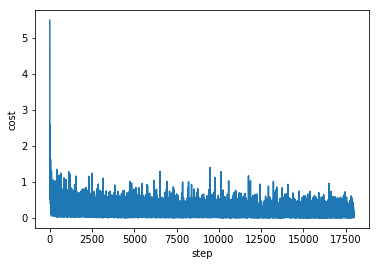

18002

In [32]:
# Optional, print the cost per training step
import pylab
pylab.figure()
pylab.plot(costs)
pylab.xlabel('step')
pylab.ylabel('cost')
pylab.show()

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_records/checkpoint-18000


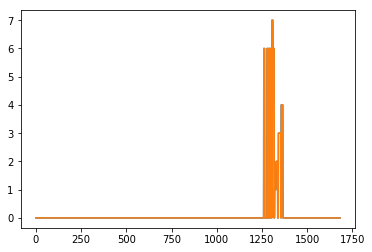

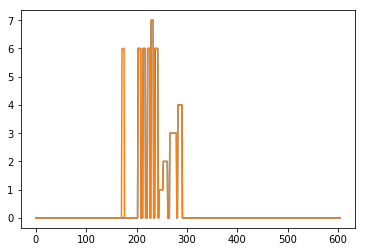

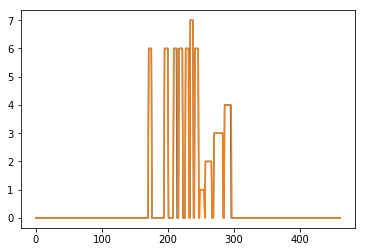

In [3]:
# Evaluate training set from a saved checkpoint (####). Remember to choose the correct checkpoint
import pylab

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-####.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-####"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        
        # Optional code for zero padding. Can replace the 3 lines above.
        #temp_n = data1.shape[0]/batch_size
        #rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        #data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        #intY = np.append(intY,np.zeros((rows_to_append,1)),axis = 0)
        #temp_n = temp_n + 1
        #data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
         
        d = {X: data1,Y:intY, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
        pylab.figure()
        pylab.plot(np.squeeze(pred[1]).reshape(-1))
        pylab.plot(intY.reshape(-1))
        pylab.show()

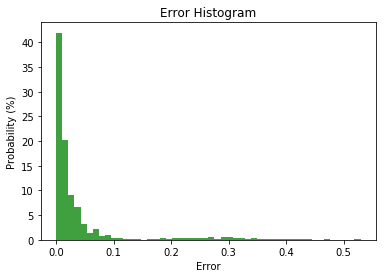

In [33]:
# Results on training set. Calculates the error histogram on the training set files. 
# Error is the fraction of mismatched bins.
pylab.figure()
n, bins, patches = pylab.hist([np.mean(err) for err in errors], 50, normed=True, facecolor='green', alpha=0.75)
pylab.xlabel('Error')
pylab.ylabel('Probability (%)')
pylab.title('Error Histogram')
pylab.show()
# print np.mean([np.mean(err) for err in errors]) # uncomment to calculate mean error

In [11]:
# Use the trained model to label the test set or unlabeled data.
# Remember to choose the correct checkpoint (####).
import glob
os.chdir(test_data_directory)
file_list = glob.glob('*.mat')

# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-####.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-####"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)

    # Run evaluation.
    # load current training file
    keys = np.zeros((len(file_list),), dtype=np.object)
    estimates = np.zeros((len(file_list),), dtype=np.object)
    file_num = 0
    for fname in file_list:
    #fname = file_list[file_num]
        print fname
        keys[file_num] = fname    
        data = cpio.loadmat(test_data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        print data1.shape
        temp_n = data1.shape[0]/batch_size
        rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        print data1.shape
        temp_n = temp_n + 1
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        print data1.shape
        d = {X: data1, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        estim = np.squeeze(pred[1]).reshape(-1)
        estimates[file_num] = estim
        file_num = file_num + 1

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lrb853_15/training_records/checkpoint-17815
lrb85315_1000_2017_03_24_07_01_21.mat
(6899, 513)
(6908, 513)
(11, 628, 513)
lrb85315_1001_2017_03_24_07_01_49.mat
(3623, 513)
(3630, 513)
(11, 330, 513)
lrb85315_1002_2017_03_24_07_02_17.mat
(4344, 513)
(4345, 513)
(11, 395, 513)
lrb85315_1003_2017_03_24_07_02_31.mat
(5159, 513)
(5170, 513)
(11, 470, 513)
lrb85315_1004_2017_03_24_07_02_59.mat
(3902, 513)
(3905, 513)
(11, 355, 513)
lrb85315_1005_2017_03_24_07_03_11.mat
(4891, 513)
(4895, 513)
(11, 445, 513)
lrb85315_1006_2017_03_24_07_03_34.mat
(5223, 513)
(5225, 513)
(11, 475, 513)
lrb85315_1007_2017_03_24_07_04_00.mat
(7104, 513)
(7106, 513)
(11, 646, 513)
lrb85315_1008_2017_03_24_07_04_40.mat
(13187, 513)
(13189, 513)
(11, 1199, 513)
lrb85315_1009_2017_03_24_07_08_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_100_2017_03_08_14_24_01.mat
(1724, 513)
(1727, 513)
(11, 157, 513)
lrb85315_

lrb85315_1096_2017_03_27_06_46_11.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1097_2017_03_27_06_46_21.mat
(1241, 513)
(1243, 513)
(11, 113, 513)
lrb85315_1098_2017_03_27_06_46_25.mat
(2091, 513)
(2101, 513)
(11, 191, 513)
lrb85315_1099_2017_03_27_06_46_44.mat
(5335, 513)
(5346, 513)
(11, 486, 513)
lrb85315_109_2017_03_08_14_25_51.mat
(604, 513)
(605, 513)
(11, 55, 513)
lrb85315_10_2017_03_03_10_37_48.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1100_2017_03_27_06_47_09.mat
(4572, 513)
(4576, 513)
(11, 416, 513)
lrb85315_1101_2017_03_27_06_47_38.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1102_2017_03_27_06_47_42.mat
(5032, 513)
(5038, 513)
(11, 458, 513)
lrb85315_1103_2017_03_27_06_47_59.mat
(4924, 513)
(4928, 513)
(11, 448, 513)
lrb85315_1104_2017_03_27_06_48_34.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1105_2017_03_27_06_48_45.mat
(5367, 513)
(5368, 513)
(11, 488, 513)
lrb85315_1106_2017_03_27_06_49_00.mat
(6418, 513)
(6424, 513)
(11, 584, 513)
lrb85

lrb85315_1192_2017_03_27_08_18_21.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1193_2017_03_27_08_18_30.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1194_2017_03_27_08_20_59.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1195_2017_03_27_08_21_14.mat
(1688, 513)
(1694, 513)
(11, 154, 513)
lrb85315_1196_2017_03_27_08_24_37.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lrb85315_1197_2017_03_27_08_24_44.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1198_2017_03_27_08_24_53.mat
(2600, 513)
(2607, 513)
(11, 237, 513)
lrb85315_1199_2017_03_27_08_25_07.mat
(5606, 513)
(5610, 513)
(11, 510, 513)
lrb85315_119_2017_03_08_14_27_11.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_11_2017_03_03_16_36_33.mat
(1042, 513)
(1045, 513)
(11, 95, 513)
lrb85315_1200_2017_03_27_08_25_48.mat
(1482, 513)
(1485, 513)
(11, 135, 513)
lrb85315_1201_2017_03_27_08_26_08.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1202_2017_03_27_08_27_39.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb

lrb85315_128_2017_03_08_14_28_19.mat
(1965, 513)
(1969, 513)
(11, 179, 513)
lrb85315_1290_2017_03_29_07_07_53.mat
(7657, 513)
(7667, 513)
(11, 697, 513)
lrb85315_1291_2017_03_29_07_08_20.mat
(4662, 513)
(4664, 513)
(11, 424, 513)
lrb85315_1292_2017_03_29_07_08_44.mat
(5540, 513)
(5544, 513)
(11, 504, 513)
lrb85315_1293_2017_03_29_07_09_06.mat
(3795, 513)
(3806, 513)
(11, 346, 513)
lrb85315_1294_2017_03_29_07_11_59.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1295_2017_03_29_07_13_45.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1296_2017_03_29_07_14_09.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1297_2017_03_29_07_14_18.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1298_2017_03_29_07_16_43.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1299_2017_03_29_07_18_03.mat
(4177, 513)
(4180, 513)
(11, 380, 513)
lrb85315_129_2017_03_08_14_28_27.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_12_2017_03_06_09_54_50.mat
(690, 513)
(693, 513)
(11, 63, 513)
lrb853

lrb85315_1386_2017_03_29_09_20_08.mat
(1278, 513)
(1287, 513)
(11, 117, 513)
lrb85315_1387_2017_03_29_09_20_12.mat
(4621, 513)
(4631, 513)
(11, 421, 513)
lrb85315_1388_2017_03_29_09_20_45.mat
(1428, 513)
(1430, 513)
(11, 130, 513)
lrb85315_1389_2017_03_29_09_20_51.mat
(7766, 513)
(7777, 513)
(11, 707, 513)
lrb85315_138_2017_03_08_14_31_39.mat
(397, 513)
(407, 513)
(11, 37, 513)
lrb85315_1390_2017_03_29_09_21_26.mat
(7175, 513)
(7183, 513)
(11, 653, 513)
lrb85315_1391_2017_03_29_09_22_08.mat
(1764, 513)
(1771, 513)
(11, 161, 513)
lrb85315_1392_2017_03_29_09_22_15.mat
(10387, 513)
(10395, 513)
(11, 945, 513)
lrb85315_1393_2017_03_30_06_07_35.mat
(593, 513)
(594, 513)
(11, 54, 513)
lrb85315_1394_2017_03_30_06_29_30.mat
(591, 513)
(594, 513)
(11, 54, 513)
lrb85315_1395_2017_03_30_06_29_56.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_1396_2017_03_30_06_30_31.mat
(574, 513)
(583, 513)
(11, 53, 513)
lrb85315_1397_2017_03_30_06_31_10.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_1398_20

(6734, 513)
(6743, 513)
(11, 613, 513)
lrb85315_1484_2017_04_01_06_47_58.mat
(4724, 513)
(4730, 513)
(11, 430, 513)
lrb85315_1485_2017_04_01_06_48_38.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1486_2017_04_01_06_48_53.mat
(4648, 513)
(4653, 513)
(11, 423, 513)
lrb85315_1487_2017_04_01_06_49_13.mat
(5656, 513)
(5665, 513)
(11, 515, 513)
lrb85315_1488_2017_04_01_06_49_54.mat
(4820, 513)
(4829, 513)
(11, 439, 513)
lrb85315_1489_2017_04_01_06_50_14.mat
(5047, 513)
(5049, 513)
(11, 459, 513)
lrb85315_148_2017_03_09_09_42_27.mat
(2548, 513)
(2552, 513)
(11, 232, 513)
lrb85315_1490_2017_04_01_06_50_37.mat
(3876, 513)
(3883, 513)
(11, 353, 513)
lrb85315_1491_2017_04_01_06_50_53.mat
(5175, 513)
(5181, 513)
(11, 471, 513)
lrb85315_1492_2017_04_01_06_51_18.mat
(4365, 513)
(4367, 513)
(11, 397, 513)
lrb85315_1493_2017_04_01_06_52_13.mat
(6012, 513)
(6017, 513)
(11, 547, 513)
lrb85315_1494_2017_04_01_06_52_41.mat
(5202, 513)
(5203, 513)
(11, 473, 513)
lrb85315_1495_2017_04_01_06_57_55.mat


lrb85315_157_2017_03_09_09_49_35.mat
(7172, 513)
(7183, 513)
(11, 653, 513)
lrb85315_1580_2017_04_01_07_55_52.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1581_2017_04_01_07_56_23.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1582_2017_04_01_07_58_02.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1583_2017_04_01_07_58_38.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1584_2017_04_01_08_00_24.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1585_2017_04_01_08_01_35.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1586_2017_04_01_08_03_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1587_2017_04_01_08_03_20.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1588_2017_04_01_08_04_08.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1589_2017_04_01_08_04_12.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_1590_2017_04_01_08_05_08.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1591_2017_04_01_08_05_12.mat
(1101, 513)
(1111, 513)
(11, 101, 513)


lrb85315_1678_2017_04_01_09_35_44.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1679_2017_04_01_09_36_04.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_167_2017_03_09_13_20_50.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_1680_2017_04_01_09_42_02.mat
(1815, 513)
(1826, 513)
(11, 166, 513)
lrb85315_1681_2017_04_01_09_44_45.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1682_2017_04_01_09_46_08.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1683_2017_04_01_09_46_28.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1684_2017_04_01_09_51_13.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1685_2017_04_01_09_51_39.mat
(2610, 513)
(2618, 513)
(11, 238, 513)
lrb85315_1686_2017_04_01_09_51_46.mat
(1793, 513)
(1804, 513)
(11, 164, 513)
lrb85315_1687_2017_04_01_09_52_10.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lrb85315_1688_2017_04_01_09_53_23.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1689_2017_04_01_09_54_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)


lrb85315_1774_2017_04_03_08_02_50.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_1775_2017_04_03_08_03_07.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1776_2017_04_03_08_03_46.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1777_2017_04_03_08_05_21.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lrb85315_1778_2017_04_03_08_09_00.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1779_2017_04_03_08_09_27.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_177_2017_03_10_09_01_43.mat
(1198, 513)
(1199, 513)
(11, 109, 513)
lrb85315_1780_2017_04_03_08_13_35.mat
(3635, 513)
(3641, 513)
(11, 331, 513)
lrb85315_1781_2017_04_03_08_15_07.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_1782_2017_04_03_08_17_20.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_1783_2017_04_03_08_17_35.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1784_2017_04_03_08_17_50.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1785_2017_04_03_08_18_08.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lr

lrb85315_1871_2017_04_06_06_29_41.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1872_2017_04_06_06_30_16.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1873_2017_04_06_06_33_32.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1874_2017_04_06_06_34_15.mat
(3096, 513)
(3102, 513)
(11, 282, 513)
lrb85315_1875_2017_04_06_06_34_27.mat
(6663, 513)
(6666, 513)
(11, 606, 513)
lrb85315_1876_2017_04_06_06_34_55.mat
(8286, 513)
(8294, 513)
(11, 754, 513)
lrb85315_1877_2017_04_06_06_35_35.mat
(8719, 513)
(8723, 513)
(11, 793, 513)
lrb85315_1878_2017_04_06_06_37_40.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1879_2017_04_06_06_38_10.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_187_2017_03_11_09_48_57.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_1880_2017_04_06_06_41_38.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1881_2017_04_06_06_49_10.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1882_2017_04_06_06_50_32.mat
(1595, 513)
(1606, 513)
(11, 146, 513)


lrb85315_1968_2017_04_06_08_58_09.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1969_2017_04_06_08_58_57.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_196_2017_03_11_09_50_00.mat
(1257, 513)
(1265, 513)
(11, 115, 513)
lrb85315_1970_2017_04_06_08_59_19.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1971_2017_04_06_09_00_53.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1972_2017_04_06_09_01_01.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1973_2017_04_06_09_01_23.mat
(1915, 513)
(1925, 513)
(11, 175, 513)
lrb85315_1974_2017_04_06_09_02_31.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_1975_2017_04_06_09_03_15.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_1976_2017_04_06_09_05_06.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_1977_2017_04_06_09_07_02.mat
(2265, 513)
(2266, 513)
(11, 206, 513)
lrb85315_1978_2017_04_06_09_07_14.mat
(3579, 513)
(3586, 513)
(11, 326, 513)
lrb85315_1979_2017_04_06_09_07_25.mat
(6550, 513)
(6556, 513)
(11, 596, 513)


lrb85315_2064_2017_04_07_07_42_24.mat
(9213, 513)
(9218, 513)
(11, 838, 513)
lrb85315_2065_2017_04_07_07_42_50.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2066_2017_04_07_07_43_02.mat
(4682, 513)
(4686, 513)
(11, 426, 513)
lrb85315_2067_2017_04_07_07_43_26.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2068_2017_04_07_07_43_45.mat
(3113, 513)
(3124, 513)
(11, 284, 513)
lrb85315_2069_2017_04_07_07_44_01.mat
(4027, 513)
(4037, 513)
(11, 367, 513)
lrb85315_206_2017_03_11_09_51_31.mat
(6199, 513)
(6204, 513)
(11, 564, 513)
lrb85315_2070_2017_04_07_07_44_48.mat
(2945, 513)
(2948, 513)
(11, 268, 513)
lrb85315_2071_2017_04_07_07_45_16.mat
(4919, 513)
(4928, 513)
(11, 448, 513)
lrb85315_2072_2017_04_07_07_46_35.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2073_2017_04_07_07_47_56.mat
(1802, 513)
(1804, 513)
(11, 164, 513)
lrb85315_2074_2017_04_07_07_48_03.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lrb85315_2075_2017_04_07_07_49_25.mat
(1122, 513)
(1133, 513)
(11, 103, 513)


lrb85315_2160_2017_04_10_07_00_38.mat
(3980, 513)
(3982, 513)
(11, 362, 513)
lrb85315_2161_2017_04_10_07_01_14.mat
(8408, 513)
(8415, 513)
(11, 765, 513)
lrb85315_2162_2017_04_10_07_03_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2163_2017_04_10_07_03_14.mat
(5523, 513)
(5533, 513)
(11, 503, 513)
lrb85315_2164_2017_04_10_07_03_40.mat
(5256, 513)
(5258, 513)
(11, 478, 513)
lrb85315_2165_2017_04_10_07_03_56.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2166_2017_04_10_07_10_40.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lrb85315_2167_2017_04_10_07_10_47.mat
(7605, 513)
(7612, 513)
(11, 692, 513)
lrb85315_2168_2017_04_10_07_11_41.mat
(7030, 513)
(7040, 513)
(11, 640, 513)
lrb85315_2169_2017_04_10_07_20_36.mat
(6806, 513)
(6809, 513)
(11, 619, 513)
lrb85315_216_2017_03_11_10_08_52.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lrb85315_2170_2017_04_10_07_26_32.mat
(4411, 513)
(4422, 513)
(11, 402, 513)
lrb85315_2171_2017_04_10_07_26_57.mat
(1124, 513)
(1133, 513)
(11, 103, 513)


lrb85315_2257_2017_04_16_06_32_33.mat
(2029, 513)
(2035, 513)
(11, 185, 513)
lrb85315_2258_2017_04_16_06_37_05.mat
(2167, 513)
(2178, 513)
(11, 198, 513)
lrb85315_2259_2017_04_16_06_37_16.mat
(6839, 513)
(6842, 513)
(11, 622, 513)
lrb85315_225_2017_03_11_13_42_41.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2260_2017_04_16_06_41_43.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2261_2017_04_16_06_44_44.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2262_2017_04_16_06_46_52.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2263_2017_04_16_06_48_02.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2264_2017_04_16_06_50_01.mat
(1084, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2265_2017_04_16_06_50_37.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2266_2017_04_16_06_50_42.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2267_2017_04_16_06_54_13.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2268_2017_04_16_06_54_47.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lr

lrb85315_2353_2017_04_16_08_05_52.mat
(3420, 513)
(3421, 513)
(11, 311, 513)
lrb85315_2354_2017_04_16_08_07_26.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2355_2017_04_16_08_08_01.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2356_2017_04_16_08_09_02.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2357_2017_04_16_08_09_22.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2358_2017_04_16_08_11_20.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2359_2017_04_16_08_12_35.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_235_2017_03_11_15_43_18.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_2360_2017_04_16_08_12_55.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2361_2017_04_16_08_16_48.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2362_2017_04_16_08_17_26.mat
(7992, 513)
(7997, 513)
(11, 727, 513)
lrb85315_2363_2017_04_16_08_18_18.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2364_2017_04_16_08_19_18.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
l

lrb85315_244_2017_03_11_17_02_44.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2450_2017_04_18_06_15_00.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2451_2017_04_18_06_15_04.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lrb85315_2452_2017_04_18_06_15_07.mat
(4994, 513)
(5005, 513)
(11, 455, 513)
lrb85315_2453_2017_04_18_06_15_28.mat
(3540, 513)
(3542, 513)
(11, 322, 513)
lrb85315_2454_2017_04_18_06_15_38.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2455_2017_04_18_06_15_42.mat
(3958, 513)
(3960, 513)
(11, 360, 513)
lrb85315_2456_2017_04_18_06_16_02.mat
(4251, 513)
(4257, 513)
(11, 387, 513)
lrb85315_2457_2017_04_18_06_16_24.mat
(5623, 513)
(5632, 513)
(11, 512, 513)
lrb85315_2458_2017_04_18_06_17_00.mat
(5574, 513)
(5577, 513)
(11, 507, 513)
lrb85315_2459_2017_04_18_06_21_49.mat
(1749, 513)
(1760, 513)
(11, 160, 513)
lrb85315_245_2017_03_11_17_05_54.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2460_2017_04_18_06_22_01.mat
(4366, 513)
(4367, 513)
(11, 397, 513)
lr

lrb85315_2546_2017_04_18_08_32_55.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2547_2017_04_18_08_34_34.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2548_2017_04_18_08_39_39.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2549_2017_04_18_08_39_46.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_254_2017_03_11_20_38_43.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2550_2017_04_18_08_39_50.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2551_2017_04_18_08_40_10.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2552_2017_04_18_08_40_48.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_2553_2017_04_18_08_46_09.mat
(2083, 513)
(2090, 513)
(11, 190, 513)
lrb85315_2554_2017_04_18_08_47_22.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2555_2017_04_18_08_49_42.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2556_2017_04_18_08_49_51.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2557_2017_04_18_08_49_55.mat
(3200, 513)
(3201, 513)
(11, 291, 513)


(15602, 513)
(15609, 513)
(11, 1419, 513)
lrb85315_2665_2017_04_19_07_18_46.mat
(25714, 513)
(25718, 513)
(11, 2338, 513)
lrb85315_2666_2017_04_19_07_19_31.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2668_2017_04_19_07_19_57.mat
(7479, 513)
(7480, 513)
(11, 680, 513)
lrb85315_2669_2017_04_19_07_22_27.mat
(4145, 513)
(4147, 513)
(11, 377, 513)
lrb85315_266_2017_03_12_07_25_17.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2670_2017_04_19_07_22_48.mat
(30866, 513)
(30877, 513)
(11, 2807, 513)
lrb85315_2671_2017_04_19_07_23_23.mat
(3330, 513)
(3333, 513)
(11, 303, 513)
lrb85315_2672_2017_04_19_07_23_32.mat
(6099, 513)
(6105, 513)
(11, 555, 513)
lrb85315_2673_2017_04_19_07_23_59.mat
(9746, 513)
(9757, 513)
(11, 887, 513)
lrb85315_2674_2017_04_19_07_24_13.mat
(25685, 513)
(25696, 513)
(11, 2336, 513)
lrb85315_2675_2017_04_19_07_24_37.mat
(5381, 513)
(5390, 513)
(11, 490, 513)
lrb85315_2677_2017_04_19_07_25_25.mat
(6349, 513)
(6358, 513)
(11, 578, 513)
lrb85315_2678_2017_04_19_0

lrb85315_2777_2017_04_20_06_10_42.mat
(7366, 513)
(7370, 513)
(11, 670, 513)
lrb85315_2778_2017_04_20_06_11_27.mat
(1873, 513)
(1881, 513)
(11, 171, 513)
lrb85315_2779_2017_04_20_06_11_45.mat
(4858, 513)
(4862, 513)
(11, 442, 513)
lrb85315_277_2017_03_12_08_29_45.mat
(2339, 513)
(2343, 513)
(11, 213, 513)
lrb85315_2780_2017_04_20_06_12_12.mat
(3817, 513)
(3828, 513)
(11, 348, 513)
lrb85315_2781_2017_04_20_06_12_36.mat
(7430, 513)
(7436, 513)
(11, 676, 513)
lrb85315_2782_2017_04_20_06_15_35.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2783_2017_04_20_06_16_20.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2784_2017_04_20_06_20_44.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2785_2017_04_20_06_22_51.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2786_2017_04_20_06_24_35.mat
(3318, 513)
(3322, 513)
(11, 302, 513)
lrb85315_2787_2017_04_20_06_24_46.mat
(5238, 513)
(5247, 513)
(11, 477, 513)
lrb85315_2788_2017_04_20_06_25_03.mat
(1098, 513)
(1100, 513)
(11, 100, 513)


lrb85315_2873_2017_04_20_07_33_55.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_2874_2017_04_20_07_36_47.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2875_2017_04_20_07_37_21.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2876_2017_04_20_07_37_55.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_2877_2017_04_20_07_39_37.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lrb85315_2878_2017_04_20_07_40_57.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_2879_2017_04_20_07_41_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_287_2017_03_12_10_29_14.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2880_2017_04_20_07_41_13.mat
(6815, 513)
(6820, 513)
(11, 620, 513)
lrb85315_2881_2017_04_20_07_41_35.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2882_2017_04_20_07_43_01.mat
(1352, 513)
(1353, 513)
(11, 123, 513)
lrb85315_2883_2017_04_20_07_43_08.mat
(1872, 513)
(1881, 513)
(11, 171, 513)
lrb85315_2884_2017_04_20_07_43_25.mat
(3508, 513)
(3509, 513)
(11, 319, 513)


lrb85315_296_2017_03_12_12_18_02.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_2970_2017_04_21_06_09_34.mat
(1348, 513)
(1353, 513)
(11, 123, 513)
lrb85315_2971_2017_04_21_06_09_40.mat
(5369, 513)
(5379, 513)
(11, 489, 513)
lrb85315_2972_2017_04_21_06_10_04.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2973_2017_04_21_06_10_08.mat
(4669, 513)
(4675, 513)
(11, 425, 513)
lrb85315_2974_2017_04_21_06_10_30.mat
(6163, 513)
(6171, 513)
(11, 561, 513)
lrb85315_2975_2017_04_21_06_11_06.mat
(1620, 513)
(1628, 513)
(11, 148, 513)
lrb85315_2976_2017_04_21_06_11_16.mat
(7011, 513)
(7018, 513)
(11, 638, 513)
lrb85315_2977_2017_04_21_06_14_09.mat
(2758, 513)
(2761, 513)
(11, 251, 513)
lrb85315_2978_2017_04_21_06_14_21.mat
(4516, 513)
(4521, 513)
(11, 411, 513)
lrb85315_2979_2017_04_21_06_14_35.mat
(1152, 513)
(1155, 513)
(11, 105, 513)
lrb85315_297_2017_03_12_12_25_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_2980_2017_04_21_06_14_50.mat
(5310, 513)
(5313, 513)
(11, 483, 513)
l

lrb85315_3065_2017_04_21_08_29_30.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3066_2017_04_21_08_29_52.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3067_2017_04_21_08_29_55.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3068_2017_04_21_08_30_02.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_3069_2017_04_21_08_30_13.mat
(3052, 513)
(3058, 513)
(11, 278, 513)
lrb85315_306_2017_03_12_16_38_07.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3070_2017_04_21_08_30_24.mat
(8439, 513)
(8448, 513)
(11, 768, 513)
lrb85315_3071_2017_04_21_08_30_53.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3072_2017_04_21_08_30_58.mat
(25, 513)
(33, 513)
(11, 3, 513)
lrb85315_3073_2017_04_21_08_31_25.mat
(5895, 513)
(5896, 513)
(11, 536, 513)
lrb85315_3074_2017_04_21_08_32_08.mat
(5969, 513)
(5973, 513)
(11, 543, 513)
lrb85315_3075_2017_04_21_08_32_35.mat
(8314, 513)
(8316, 513)
(11, 756, 513)
lrb85315_3076_2017_04_21_08_33_04.mat
(6838, 513)
(6842, 513)
(11, 622, 513)
lrb853

lrb85315_3161_2017_04_23_05_59_26.mat
(8333, 513)
(8338, 513)
(11, 758, 513)
lrb85315_3162_2017_04_23_06_00_17.mat
(2947, 513)
(2948, 513)
(11, 268, 513)
lrb85315_3163_2017_04_23_06_00_27.mat
(6026, 513)
(6028, 513)
(11, 548, 513)
lrb85315_3164_2017_04_23_06_01_48.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3165_2017_04_23_06_02_55.mat
(4029, 513)
(4037, 513)
(11, 367, 513)
lrb85315_3166_2017_04_23_06_03_08.mat
(3376, 513)
(3377, 513)
(11, 307, 513)
lrb85315_3167_2017_04_23_06_03_27.mat
(5052, 513)
(5060, 513)
(11, 460, 513)
lrb85315_3168_2017_04_23_06_03_53.mat
(4341, 513)
(4345, 513)
(11, 395, 513)
lrb85315_3169_2017_04_23_06_04_09.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_316_2017_03_12_18_43_22.mat
(1283, 513)
(1287, 513)
(11, 117, 513)
lrb85315_3170_2017_04_23_06_05_11.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3171_2017_04_23_06_05_54.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3172_2017_04_23_06_06_12.mat
(1131, 513)
(1133, 513)
(11, 103, 513)


lrb85315_3258_2017_04_23_06_33_37.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3259_2017_04_23_06_34_03.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_325_2017_03_12_20_26_48.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3260_2017_04_23_06_34_11.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3261_2017_04_23_06_34_28.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3262_2017_04_23_06_34_39.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3263_2017_04_23_06_34_57.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3264_2017_04_23_06_35_10.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3265_2017_04_23_06_35_14.mat
(2095, 513)
(2101, 513)
(11, 191, 513)
lrb85315_3266_2017_04_23_06_35_49.mat
(1822, 513)
(1826, 513)
(11, 166, 513)
lrb85315_3267_2017_04_23_06_35_55.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_3268_2017_04_23_06_36_01.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3269_2017_04_23_06_36_58.mat
(1124, 513)
(1133, 513)
(11, 103, 513)


lrb85315_3354_2017_04_23_07_05_14.mat
(2110, 513)
(2112, 513)
(11, 192, 513)
lrb85315_3355_2017_04_23_07_05_24.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3356_2017_04_23_07_05_30.mat
(2386, 513)
(2387, 513)
(11, 217, 513)
lrb85315_3357_2017_04_23_07_06_09.mat
(2067, 513)
(2068, 513)
(11, 188, 513)
lrb85315_3358_2017_04_23_07_06_31.mat
(5273, 513)
(5280, 513)
(11, 480, 513)
lrb85315_3359_2017_04_23_07_06_49.mat
(6634, 513)
(6644, 513)
(11, 604, 513)
lrb85315_335_2017_03_13_07_33_00.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3360_2017_04_23_07_07_09.mat
(2741, 513)
(2750, 513)
(11, 250, 513)
lrb85315_3361_2017_04_23_07_07_16.mat
(6148, 513)
(6149, 513)
(11, 559, 513)
lrb85315_3362_2017_04_23_07_07_46.mat
(5495, 513)
(5500, 513)
(11, 500, 513)
lrb85315_3363_2017_04_23_07_08_06.mat
(5103, 513)
(5104, 513)
(11, 464, 513)
lrb85315_3364_2017_04_23_07_08_21.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3365_2017_04_23_07_08_34.mat
(7918, 513)
(7920, 513)
(11, 720, 513)


lrb85315_3450_2017_04_23_07_49_01.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3451_2017_04_23_07_49_22.mat
(2435, 513)
(2442, 513)
(11, 222, 513)
lrb85315_3452_2017_04_23_07_49_51.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3453_2017_04_23_07_50_06.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lrb85315_3454_2017_04_23_07_50_10.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3455_2017_04_23_07_50_14.mat
(1689, 513)
(1694, 513)
(11, 154, 513)
lrb85315_3456_2017_04_23_07_50_26.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3457_2017_04_23_07_50_33.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lrb85315_3458_2017_04_23_07_50_38.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3459_2017_04_23_07_51_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_345_2017_03_13_07_36_28.mat
(1942, 513)
(1947, 513)
(11, 177, 513)
lrb85315_3460_2017_04_23_07_51_21.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3461_2017_04_23_07_51_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)


lrb85315_3547_2017_04_23_08_19_38.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3548_2017_04_23_08_20_45.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3549_2017_04_23_08_20_54.mat
(2350, 513)
(2354, 513)
(11, 214, 513)
lrb85315_354_2017_03_13_08_00_21.mat
(1526, 513)
(1529, 513)
(11, 139, 513)
lrb85315_3550_2017_04_23_08_21_01.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3551_2017_04_23_08_21_27.mat
(2698, 513)
(2706, 513)
(11, 246, 513)
lrb85315_3552_2017_04_23_08_21_49.mat
(1915, 513)
(1925, 513)
(11, 175, 513)
lrb85315_3553_2017_04_23_08_22_00.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3554_2017_04_23_08_23_51.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3555_2017_04_23_08_24_25.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3556_2017_04_23_08_24_43.mat
(2388, 513)
(2398, 513)
(11, 218, 513)
lrb85315_3557_2017_04_23_08_24_58.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3558_2017_04_23_08_25_03.mat
(1133, 513)
(1144, 513)
(11, 104, 513)


lrb85315_3643_2017_04_23_09_01_18.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3644_2017_04_23_09_01_22.mat
(1113, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3645_2017_04_23_09_01_37.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3646_2017_04_23_09_02_08.mat
(2258, 513)
(2266, 513)
(11, 206, 513)
lrb85315_3647_2017_04_23_09_02_15.mat
(3114, 513)
(3124, 513)
(11, 284, 513)
lrb85315_3648_2017_04_23_09_02_36.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lrb85315_3649_2017_04_23_09_03_11.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_364_2017_03_13_09_36_43.mat
(3217, 513)
(3223, 513)
(11, 293, 513)
lrb85315_3650_2017_04_23_09_03_17.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3651_2017_04_23_09_03_20.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3652_2017_04_23_09_03_28.mat
(1345, 513)
(1353, 513)
(11, 123, 513)
lrb85315_3653_2017_04_23_09_03_43.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3654_2017_04_23_09_03_52.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_3740_2017_04_24_02_38_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3741_2017_04_24_02_38_15.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3742_2017_04_24_02_39_12.mat
(1715, 513)
(1716, 513)
(11, 156, 513)
lrb85315_3743_2017_04_24_02_39_42.mat
(2185, 513)
(2189, 513)
(11, 199, 513)
lrb85315_3744_2017_04_24_02_40_59.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3745_2017_04_24_02_41_42.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3746_2017_04_24_02_43_01.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3747_2017_04_24_02_43_22.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3748_2017_04_24_02_44_10.mat
(1604, 513)
(1606, 513)
(11, 146, 513)
lrb85315_3749_2017_04_24_02_45_26.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lrb85315_374_2017_03_16_09_48_11.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3750_2017_04_24_02_45_50.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3751_2017_04_24_02_46_18.mat
(1105, 513)
(1111, 513)
(11, 101, 513)


lrb85315_3837_2017_04_24_06_10_18.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_3838_2017_04_24_06_10_29.mat
(1738, 513)
(1749, 513)
(11, 159, 513)
lrb85315_3839_2017_04_24_06_10_37.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_383_2017_03_16_10_01_46.mat
(4091, 513)
(4092, 513)
(11, 372, 513)
lrb85315_3840_2017_04_24_06_10_48.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3841_2017_04_24_06_10_52.mat
(2213, 513)
(2222, 513)
(11, 202, 513)
lrb85315_3842_2017_04_24_06_10_58.mat
(3208, 513)
(3212, 513)
(11, 292, 513)
lrb85315_3843_2017_04_24_06_11_11.mat
(5668, 513)
(5676, 513)
(11, 516, 513)
lrb85315_3844_2017_04_24_06_11_37.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3845_2017_04_24_06_11_46.mat
(4947, 513)
(4950, 513)
(11, 450, 513)
lrb85315_3846_2017_04_24_06_12_06.mat
(7733, 513)
(7744, 513)
(11, 704, 513)
lrb85315_3847_2017_04_24_06_12_29.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3848_2017_04_24_06_12_33.mat
(1102, 513)
(1111, 513)
(11, 101, 513)


lrb85315_3933_2017_04_24_06_35_11.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3934_2017_04_24_06_35_20.mat
(2227, 513)
(2233, 513)
(11, 203, 513)
lrb85315_3935_2017_04_24_06_35_28.mat
(1115, 513)
(1122, 513)
(11, 102, 513)
lrb85315_3936_2017_04_24_06_35_31.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3937_2017_04_24_06_35_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3938_2017_04_24_06_38_16.mat
(1074, 513)
(1078, 513)
(11, 98, 513)
lrb85315_3939_2017_04_24_06_39_09.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_393_2017_03_16_10_47_58.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_3940_2017_04_24_06_39_17.mat
(1201, 513)
(1210, 513)
(11, 110, 513)
lrb85315_3941_2017_04_24_06_39_29.mat
(1141, 513)
(1144, 513)
(11, 104, 513)
lrb85315_3942_2017_04_24_06_40_46.mat
(2225, 513)
(2233, 513)
(11, 203, 513)
lrb85315_3943_2017_04_24_06_41_06.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_3944_2017_04_24_06_41_44.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
l

lrb85315_4029_2017_04_24_07_12_51.mat
(1736, 513)
(1738, 513)
(11, 158, 513)
lrb85315_402_2017_03_16_11_37_58.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4030_2017_04_24_07_12_57.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lrb85315_4031_2017_04_24_07_13_04.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4032_2017_04_24_07_13_12.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4033_2017_04_24_07_13_35.mat
(1406, 513)
(1408, 513)
(11, 128, 513)
lrb85315_4034_2017_04_24_07_13_44.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lrb85315_4035_2017_04_24_07_14_45.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4036_2017_04_24_07_15_26.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4037_2017_04_24_07_15_32.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4038_2017_04_24_07_16_43.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4039_2017_04_24_07_16_50.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_403_2017_03_16_11_38_13.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_4125_2017_04_24_07_44_48.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4126_2017_04_24_07_45_32.mat
(1320, 513)
(1331, 513)
(11, 121, 513)
lrb85315_4127_2017_04_24_07_45_50.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4128_2017_04_24_07_46_39.mat
(2082, 513)
(2090, 513)
(11, 190, 513)
lrb85315_4129_2017_04_24_07_46_48.mat
(1743, 513)
(1749, 513)
(11, 159, 513)
lrb85315_412_2017_03_16_11_40_31.mat
(7111, 513)
(7117, 513)
(11, 647, 513)
lrb85315_4130_2017_04_24_07_46_55.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4131_2017_04_24_07_47_09.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4132_2017_04_24_07_47_22.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4133_2017_04_24_07_47_56.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4134_2017_04_24_07_48_08.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4135_2017_04_24_07_48_22.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4136_2017_04_24_07_48_29.mat
(1085, 513)
(1089, 513)
(11, 99, 513)
l

lrb85315_4222_2017_04_25_07_31_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4223_2017_04_25_07_34_40.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4224_2017_04_25_07_43_52.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4225_2017_04_25_07_45_42.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4226_2017_04_25_08_14_41.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4227_2017_04_25_08_20_00.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4228_2017_04_25_08_21_19.mat
(1674, 513)
(1683, 513)
(11, 153, 513)
lrb85315_4229_2017_04_25_08_26_06.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_422_2017_03_16_11_49_14.mat
(1089, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4230_2017_04_25_08_37_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4231_2017_04_25_08_47_42.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4232_2017_04_25_08_53_45.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4233_2017_04_25_08_56_22.mat
(1110, 513)
(1111, 513)
(11, 101, 513)


lrb85315_431_2017_03_17_05_50_36.mat
(561, 513)
(572, 513)
(11, 52, 513)
lrb85315_4320_2017_04_26_08_23_46.mat
(4829, 513)
(4840, 513)
(11, 440, 513)
lrb85315_4321_2017_04_26_08_24_48.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4322_2017_04_26_08_25_39.mat
(6179, 513)
(6182, 513)
(11, 562, 513)
lrb85315_4323_2017_04_26_08_26_04.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lrb85315_4324_2017_04_26_08_26_08.mat
(2982, 513)
(2992, 513)
(11, 272, 513)
lrb85315_4325_2017_04_26_08_26_33.mat
(1222, 513)
(1232, 513)
(11, 112, 513)
lrb85315_4326_2017_04_26_08_47_37.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4327_2017_04_26_09_06_47.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4328_2017_04_26_09_20_52.mat
(1665, 513)
(1672, 513)
(11, 152, 513)
lrb85315_4329_2017_04_27_00_42_19.mat
(566, 513)
(572, 513)
(11, 52, 513)
lrb85315_432_2017_03_17_05_50_57.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_4330_2017_04_27_00_54_59.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_4331

lrb85315_4416_2017_04_27_08_23_11.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4417_2017_04_27_08_23_30.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lrb85315_4418_2017_04_27_08_23_43.mat
(2747, 513)
(2750, 513)
(11, 250, 513)
lrb85315_4419_2017_04_27_08_23_58.mat
(7331, 513)
(7337, 513)
(11, 667, 513)
lrb85315_441_2017_03_17_06_53_13.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4420_2017_04_27_08_24_36.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4421_2017_04_27_08_24_48.mat
(3738, 513)
(3740, 513)
(11, 340, 513)
lrb85315_4422_2017_04_27_08_25_07.mat
(6672, 513)
(6677, 513)
(11, 607, 513)
lrb85315_4423_2017_04_27_08_25_55.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4424_2017_04_27_08_26_28.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4425_2017_04_27_08_26_43.mat
(3715, 513)
(3718, 513)
(11, 338, 513)
lrb85315_4426_2017_04_27_08_26_54.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
lrb85315_4427_2017_04_27_08_27_01.mat
(2533, 513)
(2541, 513)
(11, 231, 513)


lrb85315_4512_2017_04_28_08_46_08.mat
(4089, 513)
(4092, 513)
(11, 372, 513)
lrb85315_4513_2017_04_28_08_46_35.mat
(3647, 513)
(3652, 513)
(11, 332, 513)
lrb85315_4514_2017_04_28_08_47_12.mat
(3126, 513)
(3135, 513)
(11, 285, 513)
lrb85315_4515_2017_04_28_08_47_20.mat
(2338, 513)
(2343, 513)
(11, 213, 513)
lrb85315_4516_2017_04_28_08_47_27.mat
(3453, 513)
(3454, 513)
(11, 314, 513)
lrb85315_4517_2017_04_28_08_47_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4518_2017_04_28_08_48_04.mat
(3963, 513)
(3971, 513)
(11, 361, 513)
lrb85315_4519_2017_04_28_08_48_23.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lrb85315_451_2017_03_17_07_10_50.mat
(7781, 513)
(7788, 513)
(11, 708, 513)
lrb85315_4520_2017_04_28_08_48_29.mat
(6298, 513)
(6303, 513)
(11, 573, 513)
lrb85315_4521_2017_04_28_08_49_18.mat
(1165, 513)
(1166, 513)
(11, 106, 513)
lrb85315_4522_2017_04_28_08_50_59.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4523_2017_04_28_08_51_09.mat
(1123, 513)
(1133, 513)
(11, 103, 513)


lrb85315_4609_2017_05_04_05_50_46.mat
(7472, 513)
(7480, 513)
(11, 680, 513)
lrb85315_460_2017_03_17_07_29_25.mat
(4017, 513)
(4026, 513)
(11, 366, 513)
lrb85315_4610_2017_05_04_05_51_18.mat
(7284, 513)
(7293, 513)
(11, 663, 513)
lrb85315_4611_2017_05_04_05_52_24.mat
(8683, 513)
(8690, 513)
(11, 790, 513)
lrb85315_4612_2017_05_04_05_53_00.mat
(5588, 513)
(5599, 513)
(11, 509, 513)
lrb85315_4613_2017_05_04_06_02_11.mat
(4400, 513)
(4411, 513)
(11, 401, 513)
lrb85315_4614_2017_05_04_06_02_35.mat
(6991, 513)
(6996, 513)
(11, 636, 513)
lrb85315_4615_2017_05_04_06_03_20.mat
(8435, 513)
(8437, 513)
(11, 767, 513)
lrb85315_4616_2017_05_04_06_10_39.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4617_2017_05_04_06_10_56.mat
(7682, 513)
(7689, 513)
(11, 699, 513)
lrb85315_4618_2017_05_04_06_11_21.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4619_2017_05_04_06_11_24.mat
(8551, 513)
(8558, 513)
(11, 778, 513)
lrb85315_461_2017_03_17_07_29_44.mat
(2233, 513)
(2244, 513)
(11, 204, 513)
l

lrb85315_4705_2017_05_05_08_17_56.mat
(4177, 513)
(4180, 513)
(11, 380, 513)
lrb85315_4706_2017_05_05_08_19_34.mat
(8372, 513)
(8382, 513)
(11, 762, 513)
lrb85315_4707_2017_05_05_08_20_12.mat
(5580, 513)
(5588, 513)
(11, 508, 513)
lrb85315_4708_2017_05_05_08_57_13.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4709_2017_05_05_09_04_08.mat
(2477, 513)
(2486, 513)
(11, 226, 513)
lrb85315_470_2017_03_17_07_33_30.mat
(4704, 513)
(4708, 513)
(11, 428, 513)
lrb85315_4710_2017_05_05_09_04_21.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4711_2017_05_05_09_04_25.mat
(9282, 513)
(9284, 513)
(11, 844, 513)
lrb85315_4712_2017_05_05_09_04_54.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lrb85315_4713_2017_05_05_09_05_05.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4714_2017_05_05_09_05_22.mat
(2428, 513)
(2431, 513)
(11, 221, 513)
lrb85315_4715_2017_05_05_09_05_29.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4716_2017_05_05_09_05_34.mat
(1117, 513)
(1122, 513)
(11, 102, 513)


lrb85315_4801_2017_05_10_08_31_06.mat
(2378, 513)
(2387, 513)
(11, 217, 513)
lrb85315_4802_2017_05_10_08_31_12.mat
(3031, 513)
(3036, 513)
(11, 276, 513)
lrb85315_4803_2017_05_10_08_31_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4804_2017_05_10_08_31_34.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_4805_2017_05_10_08_31_38.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_4806_2017_05_10_08_31_46.mat
(2859, 513)
(2860, 513)
(11, 260, 513)
lrb85315_4807_2017_05_10_08_31_56.mat
(1758, 513)
(1760, 513)
(11, 160, 513)
lrb85315_4808_2017_05_10_08_32_03.mat
(4678, 513)
(4686, 513)
(11, 426, 513)
lrb85315_4809_2017_05_10_08_32_26.mat
(4878, 513)
(4884, 513)
(11, 444, 513)
lrb85315_480_2017_03_17_08_14_45.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4810_2017_05_10_08_32_46.mat
(4440, 513)
(4444, 513)
(11, 404, 513)
lrb85315_4811_2017_05_10_08_33_05.mat
(3816, 513)
(3817, 513)
(11, 347, 513)
lrb85315_4812_2017_05_10_08_33_41.mat
(1124, 513)
(1133, 513)
(11, 103, 513)


lrb85315_4899_2017_05_11_08_13_43.mat
(4462, 513)
(4466, 513)
(11, 406, 513)
lrb85315_489_2017_03_17_08_17_37.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_48_2017_03_06_16_55_11.mat
(4070, 513)
(4081, 513)
(11, 371, 513)
lrb85315_4900_2017_05_11_08_14_02.mat
(4243, 513)
(4246, 513)
(11, 386, 513)
lrb85315_4901_2017_05_11_08_34_54.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4902_2017_05_11_08_35_06.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_4903_2017_05_12_05_39_48.mat
(5440, 513)
(5445, 513)
(11, 495, 513)
lrb85315_4904_2017_05_12_05_40_04.mat
(1199, 513)
(1210, 513)
(11, 110, 513)
lrb85315_4905_2017_05_12_05_40_10.mat
(4645, 513)
(4653, 513)
(11, 423, 513)
lrb85315_4906_2017_05_12_05_40_27.mat
(5446, 513)
(5456, 513)
(11, 496, 513)
lrb85315_4907_2017_05_12_05_40_59.mat
(3587, 513)
(3597, 513)
(11, 327, 513)
lrb85315_4908_2017_05_12_05_46_09.mat
(4130, 513)
(4136, 513)
(11, 376, 513)
lrb85315_4909_2017_05_12_05_46_28.mat
(1246, 513)
(1254, 513)
(11, 114, 513)
lr

lrb85315_4995_2017_05_12_08_50_13.mat
(1091, 513)
(1100, 513)
(11, 100, 513)
lrb85315_4996_2017_05_12_08_50_19.mat
(2044, 513)
(2046, 513)
(11, 186, 513)
lrb85315_4997_2017_05_12_08_52_15.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_4998_2017_05_12_08_53_40.mat
(4140, 513)
(4147, 513)
(11, 377, 513)
lrb85315_4999_2017_05_12_08_53_55.mat
(3881, 513)
(3883, 513)
(11, 353, 513)
lrb85315_499_2017_03_17_08_23_02.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_49_2017_03_06_16_55_22.mat
(1142, 513)
(1144, 513)
(11, 104, 513)
lrb85315_4_2017_03_03_02_12_48.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_5000_2017_05_12_08_54_11.mat
(5674, 513)
(5676, 513)
(11, 516, 513)
lrb85315_5001_2017_05_12_08_54_35.mat
(1178, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5002_2017_05_12_08_54_41.mat
(3721, 513)
(3729, 513)
(11, 339, 513)
lrb85315_5003_2017_05_12_08_54_52.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5004_2017_05_12_08_54_56.mat
(6000, 513)
(6006, 513)
(11, 546, 513)
lrb85315

lrb85315_5090_2017_05_15_07_13_25.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5091_2017_05_15_07_14_34.mat
(2142, 513)
(2145, 513)
(11, 195, 513)
lrb85315_5092_2017_05_15_07_14_40.mat
(7130, 513)
(7139, 513)
(11, 649, 513)
lrb85315_5093_2017_05_15_07_15_09.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5094_2017_05_15_07_15_17.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_5095_2017_05_15_07_15_37.mat
(1581, 513)
(1584, 513)
(11, 144, 513)
lrb85315_5096_2017_05_15_07_15_42.mat
(5562, 513)
(5566, 513)
(11, 506, 513)
lrb85315_5097_2017_05_15_07_15_58.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5098_2017_05_15_07_16_01.mat
(9613, 513)
(9614, 513)
(11, 874, 513)
lrb85315_5099_2017_05_15_07_16_30.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_509_2017_03_17_08_33_34.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_50_2017_03_06_16_56_33.mat
(1796, 513)
(1804, 513)
(11, 164, 513)
lrb85315_5100_2017_05_15_07_16_37.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lr

lrb85315_5187_2017_05_16_05_22_01.mat
(691, 513)
(693, 513)
(11, 63, 513)
lrb85315_5188_2017_05_16_05_22_04.mat
(688, 513)
(693, 513)
(11, 63, 513)
lrb85315_5189_2017_05_16_05_22_08.mat
(666, 513)
(671, 513)
(11, 61, 513)
lrb85315_518_2017_03_17_08_37_48.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5190_2017_05_16_05_22_10.mat
(716, 513)
(726, 513)
(11, 66, 513)
lrb85315_5191_2017_05_16_05_22_13.mat
(672, 513)
(682, 513)
(11, 62, 513)
lrb85315_5192_2017_05_16_05_22_17.mat
(666, 513)
(671, 513)
(11, 61, 513)
lrb85315_5193_2017_05_16_05_22_19.mat
(888, 513)
(891, 513)
(11, 81, 513)
lrb85315_5194_2017_05_16_05_22_22.mat
(4645, 513)
(4653, 513)
(11, 423, 513)
lrb85315_5195_2017_05_16_05_22_41.mat
(11158, 513)
(11165, 513)
(11, 1015, 513)
lrb85315_5196_2017_05_16_05_24_06.mat
(3133, 513)
(3135, 513)
(11, 285, 513)
lrb85315_5197_2017_05_16_05_24_15.mat
(10730, 513)
(10736, 513)
(11, 976, 513)
lrb85315_5198_2017_05_16_05_25_00.mat
(8129, 513)
(8140, 513)
(11, 740, 513)
lrb85315_5199_20

lrb85315_5283_2017_05_16_06_32_10.mat
(6715, 513)
(6721, 513)
(11, 611, 513)
lrb85315_5284_2017_05_16_06_33_25.mat
(1555, 513)
(1562, 513)
(11, 142, 513)
lrb85315_5285_2017_05_16_06_33_34.mat
(1319, 513)
(1320, 513)
(11, 120, 513)
lrb85315_5286_2017_05_16_06_34_11.mat
(5885, 513)
(5896, 513)
(11, 536, 513)
lrb85315_5287_2017_05_16_06_34_30.mat
(7092, 513)
(7095, 513)
(11, 645, 513)
lrb85315_5288_2017_05_16_06_35_07.mat
(5569, 513)
(5577, 513)
(11, 507, 513)
lrb85315_5289_2017_05_16_06_35_51.mat
(1912, 513)
(1914, 513)
(11, 174, 513)
lrb85315_528_2017_03_17_08_45_42.mat
(3929, 513)
(3938, 513)
(11, 358, 513)
lrb85315_5290_2017_05_16_06_35_59.mat
(4547, 513)
(4554, 513)
(11, 414, 513)
lrb85315_5291_2017_05_16_06_36_22.mat
(3967, 513)
(3971, 513)
(11, 361, 513)
lrb85315_5292_2017_05_16_06_36_51.mat
(2180, 513)
(2189, 513)
(11, 199, 513)
lrb85315_5293_2017_05_16_06_37_01.mat
(8245, 513)
(8250, 513)
(11, 750, 513)
lrb85315_5294_2017_05_16_06_37_34.mat
(1123, 513)
(1133, 513)
(11, 103, 513)


lrb85315_537_2017_03_17_09_07_30.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5380_2017_05_16_08_00_21.mat
(3532, 513)
(3542, 513)
(11, 322, 513)
lrb85315_5381_2017_05_16_08_00_51.mat
(2929, 513)
(2937, 513)
(11, 267, 513)
lrb85315_5382_2017_05_16_08_25_35.mat
(4024, 513)
(4026, 513)
(11, 366, 513)
lrb85315_5383_2017_05_16_08_25_53.mat
(1187, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5384_2017_05_16_08_26_04.mat
(2238, 513)
(2244, 513)
(11, 204, 513)
lrb85315_5385_2017_05_16_08_26_15.mat
(1192, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5386_2017_05_16_08_26_19.mat
(3089, 513)
(3091, 513)
(11, 281, 513)
lrb85315_5387_2017_05_16_08_26_28.mat
(1192, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5388_2017_05_16_08_26_34.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lrb85315_5389_2017_05_16_08_26_38.mat
(1205, 513)
(1210, 513)
(11, 110, 513)
lrb85315_538_2017_03_17_09_16_00.mat
(1092, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5390_2017_05_16_08_26_42.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
l

(5698, 513)
(11, 518, 513)
lrb85315_5476_2017_05_17_05_59_25.mat
(6611, 513)
(6622, 513)
(11, 602, 513)
lrb85315_5477_2017_05_17_06_00_00.mat
(5525, 513)
(5533, 513)
(11, 503, 513)
lrb85315_5478_2017_05_17_06_00_31.mat
(8319, 513)
(8327, 513)
(11, 757, 513)
lrb85315_5479_2017_05_17_06_00_58.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lrb85315_547_2017_03_17_09_19_41.mat
(6183, 513)
(6193, 513)
(11, 563, 513)
lrb85315_5480_2017_05_17_06_01_09.mat
(7343, 513)
(7348, 513)
(11, 668, 513)
lrb85315_5481_2017_05_17_06_03_44.mat
(2711, 513)
(2717, 513)
(11, 247, 513)
lrb85315_5482_2017_05_17_06_03_53.mat
(5791, 513)
(5797, 513)
(11, 527, 513)
lrb85315_5483_2017_05_17_06_04_15.mat
(4213, 513)
(4224, 513)
(11, 384, 513)
lrb85315_5484_2017_05_17_06_04_27.mat
(5039, 513)
(5049, 513)
(11, 459, 513)
lrb85315_5485_2017_05_17_06_04_50.mat
(5877, 513)
(5885, 513)
(11, 535, 513)
lrb85315_5486_2017_05_17_06_05_08.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lrb85315_5487_2017_05_17_06_05_16.mat
(4290, 513)


lrb85315_5572_2017_05_17_07_40_18.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5573_2017_05_17_07_40_22.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5574_2017_05_17_07_52_52.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5575_2017_05_17_07_54_55.mat
(1187, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5576_2017_05_17_08_05_14.mat
(1972, 513)
(1980, 513)
(11, 180, 513)
lrb85315_5577_2017_05_17_08_05_58.mat
(4716, 513)
(4719, 513)
(11, 429, 513)
lrb85315_5578_2017_05_17_08_06_15.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lrb85315_5579_2017_05_17_08_06_55.mat
(3660, 513)
(3663, 513)
(11, 333, 513)
lrb85315_557_2017_03_17_09_45_37.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5580_2017_05_17_08_07_13.mat
(1899, 513)
(1903, 513)
(11, 173, 513)
lrb85315_5581_2017_05_17_08_07_20.mat
(1179, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5582_2017_05_17_08_07_26.mat
(1664, 513)
(1672, 513)
(11, 152, 513)
lrb85315_5583_2017_05_17_08_07_36.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lr

lrb85315_5669_2017_05_18_07_08_02.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_566_2017_03_17_10_06_27.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5670_2017_05_18_07_08_57.mat
(4037, 513)
(4048, 513)
(11, 368, 513)
lrb85315_5671_2017_05_18_07_09_35.mat
(3474, 513)
(3476, 513)
(11, 316, 513)
lrb85315_5672_2017_05_18_07_09_45.mat
(3389, 513)
(3399, 513)
(11, 309, 513)
lrb85315_5673_2017_05_18_07_10_01.mat
(1528, 513)
(1529, 513)
(11, 139, 513)
lrb85315_5674_2017_05_18_07_10_07.mat
(3489, 513)
(3498, 513)
(11, 318, 513)
lrb85315_5675_2017_05_18_07_18_40.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5676_2017_05_18_07_18_57.mat
(1751, 513)
(1760, 513)
(11, 160, 513)
lrb85315_5677_2017_05_18_07_19_03.mat
(1282, 513)
(1287, 513)
(11, 117, 513)
lrb85315_5678_2017_05_18_07_23_28.mat
(1945, 513)
(1947, 513)
(11, 177, 513)
lrb85315_5679_2017_05_18_07_23_42.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lrb85315_567_2017_03_17_10_08_57.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lr

lrb85315_5765_2017_05_20_07_20_51.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lrb85315_5766_2017_05_20_07_20_58.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5767_2017_05_20_07_21_03.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_5768_2017_05_20_07_21_12.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5769_2017_05_20_07_21_17.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_576_2017_03_19_03_19_24.mat
(544, 513)
(550, 513)
(11, 50, 513)
lrb85315_5770_2017_05_20_07_21_22.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5771_2017_05_20_07_21_25.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_5772_2017_05_20_07_21_32.mat
(1194, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5773_2017_05_20_07_21_35.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lrb85315_5774_2017_05_20_07_21_48.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lrb85315_5775_2017_05_20_07_21_53.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5776_2017_05_20_07_21_58.mat
(1947, 513)
(1958, 513)
(11, 178, 513)
lrb

lrb85315_5862_2017_05_20_08_25_05.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5863_2017_05_20_08_25_09.mat
(2072, 513)
(2079, 513)
(11, 189, 513)
lrb85315_5864_2017_05_20_08_25_15.mat
(4186, 513)
(4191, 513)
(11, 381, 513)
lrb85315_5865_2017_05_20_08_25_28.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_5866_2017_05_20_08_25_32.mat
(1248, 513)
(1254, 513)
(11, 114, 513)
lrb85315_5867_2017_05_20_08_25_36.mat
(1182, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5868_2017_05_20_08_25_41.mat
(6372, 513)
(6380, 513)
(11, 580, 513)
lrb85315_5869_2017_05_20_08_30_19.mat
(1177, 513)
(1188, 513)
(11, 108, 513)
lrb85315_586_2017_03_19_06_50_44.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_5870_2017_05_20_08_30_25.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lrb85315_5871_2017_05_20_08_30_32.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lrb85315_5872_2017_05_20_08_30_38.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_5873_2017_05_20_08_30_50.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lrb

lrb85315_5959_2017_05_20_09_15_49.mat
(1764, 513)
(1771, 513)
(11, 161, 513)
lrb85315_595_2017_03_19_07_05_20.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5960_2017_05_20_09_15_54.mat
(3910, 513)
(3916, 513)
(11, 356, 513)
lrb85315_5961_2017_05_20_09_16_07.mat
(3170, 513)
(3179, 513)
(11, 289, 513)
lrb85315_5962_2017_05_20_09_16_17.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_5963_2017_05_20_09_16_21.mat
(1688, 513)
(1694, 513)
(11, 154, 513)
lrb85315_5964_2017_05_20_09_16_26.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lrb85315_5965_2017_05_20_09_16_30.mat
(2095, 513)
(2101, 513)
(11, 191, 513)
lrb85315_5966_2017_05_20_09_16_40.mat
(1162, 513)
(1166, 513)
(11, 106, 513)
lrb85315_5967_2017_05_20_09_16_44.mat
(1713, 513)
(1716, 513)
(11, 156, 513)
lrb85315_5968_2017_05_20_09_16_49.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lrb85315_5969_2017_05_20_09_16_53.mat
(3881, 513)
(3883, 513)
(11, 353, 513)
lrb85315_596_2017_03_19_07_08_50.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_6054_2017_05_22_04_18_45.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_6055_2017_05_22_05_18_01.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_6056_2017_05_22_05_18_31.mat
(5494, 513)
(5500, 513)
(11, 500, 513)
lrb85315_6057_2017_05_22_05_18_51.mat
(6990, 513)
(6996, 513)
(11, 636, 513)
lrb85315_6058_2017_05_22_05_19_33.mat
(3672, 513)
(3674, 513)
(11, 334, 513)
lrb85315_6059_2017_05_22_05_19_45.mat
(5212, 513)
(5214, 513)
(11, 474, 513)
lrb85315_605_2017_03_19_07_12_09.mat
(4635, 513)
(4642, 513)
(11, 422, 513)
lrb85315_6060_2017_05_22_05_20_10.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85315_6061_2017_05_22_05_20_19.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lrb85315_6062_2017_05_22_05_20_25.mat
(1252, 513)
(1254, 513)
(11, 114, 513)
lrb85315_6063_2017_05_22_05_20_29.mat
(7699, 513)
(7700, 513)
(11, 700, 513)
lrb85315_6064_2017_05_22_05_22_42.mat
(1577, 513)
(1584, 513)
(11, 144, 513)
lrb85315_6065_2017_05_22_05_22_52.mat
(3688, 513)
(3696, 513)
(11, 336, 513)
lrb853

lrb85315_6150_2017_05_22_07_58_13.mat
(8760, 513)
(8767, 513)
(11, 797, 513)
lrb85315_6151_2017_05_22_07_59_00.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6152_2017_05_22_07_59_04.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_6153_2017_05_22_07_59_10.mat
(5618, 513)
(5621, 513)
(11, 511, 513)
lrb85315_6154_2017_05_22_07_59_34.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6155_2017_05_22_07_59_45.mat
(4436, 513)
(4444, 513)
(11, 404, 513)
lrb85315_6156_2017_05_22_07_59_59.mat
(3713, 513)
(3718, 513)
(11, 338, 513)
lrb85315_6157_2017_05_22_08_00_18.mat
(1195, 513)
(1199, 513)
(11, 109, 513)
lrb85315_6158_2017_05_22_08_00_24.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6159_2017_05_22_08_02_24.mat
(2997, 513)
(3003, 513)
(11, 273, 513)
lrb85315_615_2017_03_19_07_15_55.mat
(5420, 513)
(5423, 513)
(11, 493, 513)
lrb85315_6160_2017_05_22_08_02_33.mat
(6216, 513)
(6226, 513)
(11, 566, 513)
lrb85315_6161_2017_05_22_08_15_06.mat
(3856, 513)
(3861, 513)
(11, 351, 513)


lrb85315_6247_2017_05_24_07_53_46.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6248_2017_05_24_07_53_57.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6249_2017_05_24_07_54_01.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lrb85315_624_2017_03_19_07_20_01.mat
(4969, 513)
(4972, 513)
(11, 452, 513)
lrb85315_6250_2017_05_24_07_54_36.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6251_2017_05_24_07_54_48.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6252_2017_05_24_07_55_34.mat
(1753, 513)
(1760, 513)
(11, 160, 513)
lrb85315_6253_2017_05_24_07_55_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6254_2017_05_24_07_56_16.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6255_2017_05_24_07_56_21.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lrb85315_6256_2017_05_24_07_56_32.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lrb85315_6257_2017_05_24_07_56_37.mat
(1095, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6258_2017_05_24_08_10_40.mat
(1086, 513)
(1089, 513)
(11, 99, 513)
l

lrb85315_6344_2017_05_27_06_59_10.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6345_2017_05_27_07_01_35.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6346_2017_05_27_07_27_58.mat
(1228, 513)
(1232, 513)
(11, 112, 513)
lrb85315_6347_2017_05_27_07_56_40.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6348_2017_05_27_07_57_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6349_2017_05_27_07_58_04.mat
(2033, 513)
(2035, 513)
(11, 185, 513)
lrb85315_634_2017_03_19_07_27_51.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6350_2017_05_27_08_00_30.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6351_2017_05_27_08_04_05.mat
(1081, 513)
(1089, 513)
(11, 99, 513)
lrb85315_6352_2017_05_27_08_04_16.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6353_2017_05_27_08_04_54.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6354_2017_05_27_08_04_58.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lrb85315_6355_2017_05_27_08_05_07.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
l

lrb85315_6440_2017_05_31_05_45_42.mat
(5279, 513)
(5280, 513)
(11, 480, 513)
lrb85315_6441_2017_05_31_05_46_13.mat
(6744, 513)
(6754, 513)
(11, 614, 513)
lrb85315_6442_2017_05_31_06_10_26.mat
(1178, 513)
(1188, 513)
(11, 108, 513)
lrb85315_6443_2017_05_31_06_10_31.mat
(3117, 513)
(3124, 513)
(11, 284, 513)
lrb85315_6444_2017_05_31_06_10_41.mat
(5538, 513)
(5544, 513)
(11, 504, 513)
lrb85315_6445_2017_05_31_06_11_09.mat
(6013, 513)
(6017, 513)
(11, 547, 513)
lrb85315_6446_2017_05_31_06_11_27.mat
(3342, 513)
(3344, 513)
(11, 304, 513)
lrb85315_6447_2017_05_31_06_11_40.mat
(5047, 513)
(5049, 513)
(11, 459, 513)
lrb85315_6448_2017_05_31_06_12_01.mat
(1653, 513)
(1661, 513)
(11, 151, 513)
lrb85315_6449_2017_05_31_06_12_06.mat
(1229, 513)
(1232, 513)
(11, 112, 513)
lrb85315_644_2017_03_19_07_57_06.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6450_2017_05_31_06_12_13.mat
(1590, 513)
(1595, 513)
(11, 145, 513)
lrb85315_6451_2017_05_31_06_12_22.mat
(1123, 513)
(1133, 513)
(11, 103, 513)


lrb85315_6537_2017_06_02_07_32_05.mat
(3378, 513)
(3388, 513)
(11, 308, 513)
lrb85315_6538_2017_06_02_07_32_17.mat
(6135, 513)
(6138, 513)
(11, 558, 513)
lrb85315_6539_2017_06_02_07_32_41.mat
(6094, 513)
(6105, 513)
(11, 555, 513)
lrb85315_653_2017_03_19_08_28_54.mat
(1694, 513)
(1705, 513)
(11, 155, 513)
lrb85315_6540_2017_06_02_07_40_26.mat
(4469, 513)
(4477, 513)
(11, 407, 513)
lrb85315_6541_2017_06_02_07_42_06.mat
(6837, 513)
(6842, 513)
(11, 622, 513)
lrb85315_6542_2017_06_02_07_42_56.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6543_2017_06_02_07_51_12.mat
(5312, 513)
(5313, 513)
(11, 483, 513)
lrb85315_6544_2017_06_02_07_51_34.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6545_2017_06_02_07_51_39.mat
(3553, 513)
(3564, 513)
(11, 324, 513)
lrb85315_6546_2017_06_02_07_51_55.mat
(5512, 513)
(5522, 513)
(11, 502, 513)
lrb85315_6547_2017_06_02_08_04_07.mat
(4102, 513)
(4103, 513)
(11, 373, 513)
lrb85315_6548_2017_06_02_08_04_21.mat
(1138, 513)
(1144, 513)
(11, 104, 513)


lrb85315_6633_2017_06_08_07_29_20.mat
(9096, 513)
(9097, 513)
(11, 827, 513)
lrb85315_6634_2017_06_08_07_29_53.mat
(6663, 513)
(6666, 513)
(11, 606, 513)
lrb85315_6635_2017_06_08_07_31_07.mat
(9538, 513)
(9548, 513)
(11, 868, 513)
lrb85315_6636_2017_06_08_07_31_36.mat
(1713, 513)
(1716, 513)
(11, 156, 513)
lrb85315_6637_2017_06_08_07_31_41.mat
(7025, 513)
(7029, 513)
(11, 639, 513)
lrb85315_6638_2017_06_08_07_32_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6639_2017_06_08_07_32_40.mat
(6609, 513)
(6611, 513)
(11, 601, 513)
lrb85315_663_2017_03_19_23_49_10.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_6640_2017_06_08_07_33_17.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6641_2017_06_08_07_33_25.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_6642_2017_06_08_07_33_42.mat
(6074, 513)
(6083, 513)
(11, 553, 513)
lrb85315_6643_2017_06_08_07_34_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6644_2017_06_08_07_34_17.mat
(8541, 513)
(8547, 513)
(11, 777, 513)
lrb

lrb85315_672_2017_03_20_03_35_51.mat
(558, 513)
(561, 513)
(11, 51, 513)
lrb85315_6730_2017_06_09_07_44_17.mat
(4867, 513)
(4873, 513)
(11, 443, 513)
lrb85315_6731_2017_06_09_07_44_38.mat
(5653, 513)
(5654, 513)
(11, 514, 513)
lrb85315_6732_2017_06_09_08_12_54.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6733_2017_06_09_08_17_18.mat
(7281, 513)
(7282, 513)
(11, 662, 513)
lrb85315_6734_2017_06_09_08_17_38.mat
(7025, 513)
(7029, 513)
(11, 639, 513)
lrb85315_6735_2017_06_09_08_18_01.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6736_2017_06_09_08_18_07.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6737_2017_06_09_08_18_14.mat
(6274, 513)
(6281, 513)
(11, 571, 513)
lrb85315_6738_2017_06_09_08_18_56.mat
(6173, 513)
(6182, 513)
(11, 562, 513)
lrb85315_6739_2017_06_09_08_19_31.mat
(10047, 513)
(10054, 513)
(11, 914, 513)
lrb85315_673_2017_03_20_03_41_22.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_6740_2017_06_09_08_20_36.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lrb85

lrb85315_6826_2017_06_12_05_52_57.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6827_2017_06_12_05_53_14.mat
(7381, 513)
(7392, 513)
(11, 672, 513)
lrb85315_6828_2017_06_12_05_53_39.mat
(4292, 513)
(4301, 513)
(11, 391, 513)
lrb85315_6829_2017_06_12_05_54_08.mat
(6175, 513)
(6182, 513)
(11, 562, 513)
lrb85315_682_2017_03_20_06_55_44.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_6830_2017_06_12_05_54_40.mat
(5732, 513)
(5742, 513)
(11, 522, 513)
lrb85315_6831_2017_06_12_05_55_32.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_6832_2017_06_12_05_55_42.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lrb85315_6833_2017_06_12_05_55_46.mat
(1503, 513)
(1507, 513)
(11, 137, 513)
lrb85315_6834_2017_06_12_05_55_53.mat
(2306, 513)
(2310, 513)
(11, 210, 513)
lrb85315_6835_2017_06_12_05_56_01.mat
(6253, 513)
(6259, 513)
(11, 569, 513)
lrb85315_6836_2017_06_12_05_56_20.mat
(1143, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6837_2017_06_12_05_56_27.mat
(2314, 513)
(2321, 513)
(11, 211, 513)
lrb

lrb85315_6922_2017_06_12_07_43_15.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_6923_2017_06_12_07_43_19.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6924_2017_06_12_07_43_28.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6925_2017_06_12_07_43_44.mat
(8957, 513)
(8965, 513)
(11, 815, 513)
lrb85315_6926_2017_06_12_07_44_29.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_6927_2017_06_12_07_44_38.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_6928_2017_06_12_07_44_52.mat
(1505, 513)
(1507, 513)
(11, 137, 513)
lrb85315_6929_2017_06_12_07_44_57.mat
(1996, 513)
(2002, 513)
(11, 182, 513)
lrb85315_692_2017_03_20_07_04_39.mat
(5541, 513)
(5544, 513)
(11, 504, 513)
lrb85315_6930_2017_06_12_07_45_05.mat
(1454, 513)
(1463, 513)
(11, 133, 513)
lrb85315_6931_2017_06_12_07_45_11.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_6932_2017_06_12_07_45_19.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_6933_2017_06_12_07_45_22.mat
(7164, 513)
(7172, 513)
(11, 652, 513)


lrb85315_7018_2017_06_13_07_58_42.mat
(4810, 513)
(4818, 513)
(11, 438, 513)
lrb85315_7019_2017_06_13_07_59_35.mat
(1182, 513)
(1188, 513)
(11, 108, 513)
lrb85315_701_2017_03_20_07_12_15.mat
(5312, 513)
(5313, 513)
(11, 483, 513)
lrb85315_7020_2017_06_13_07_59_46.mat
(1231, 513)
(1232, 513)
(11, 112, 513)
lrb85315_7021_2017_06_13_07_59_50.mat
(1176, 513)
(1177, 513)
(11, 107, 513)
lrb85315_7022_2017_06_13_07_59_55.mat
(1231, 513)
(1232, 513)
(11, 112, 513)
lrb85315_7023_2017_06_13_07_59_59.mat
(6589, 513)
(6600, 513)
(11, 600, 513)
lrb85315_7024_2017_06_13_08_00_26.mat
(6760, 513)
(6765, 513)
(11, 615, 513)
lrb85315_7025_2017_06_13_08_00_55.mat
(5618, 513)
(5621, 513)
(11, 511, 513)
lrb85315_7026_2017_06_13_08_21_42.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_7027_2017_06_14_05_19_13.mat
(1343, 513)
(1353, 513)
(11, 123, 513)
lrb85315_7028_2017_06_14_05_19_39.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lrb85315_7029_2017_06_14_05_19_58.mat
(1234, 513)
(1243, 513)
(11, 113, 513)


lrb85315_7114_2017_06_16_06_40_09.mat
(1359, 513)
(1364, 513)
(11, 124, 513)
lrb85315_7115_2017_06_16_06_40_14.mat
(3422, 513)
(3432, 513)
(11, 312, 513)
lrb85315_7116_2017_06_16_06_40_25.mat
(4993, 513)
(4994, 513)
(11, 454, 513)
lrb85315_7117_2017_06_16_06_40_56.mat
(3491, 513)
(3498, 513)
(11, 318, 513)
lrb85315_7118_2017_06_16_06_41_08.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_7119_2017_06_16_06_41_29.mat
(2849, 513)
(2860, 513)
(11, 260, 513)
lrb85315_711_2017_03_20_07_30_55.mat
(4103, 513)
(4114, 513)
(11, 374, 513)
lrb85315_7120_2017_06_16_06_41_37.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_7121_2017_06_16_06_41_42.mat
(5902, 513)
(5907, 513)
(11, 537, 513)
lrb85315_7122_2017_06_16_06_42_29.mat
(4773, 513)
(4774, 513)
(11, 434, 513)
lrb85315_7123_2017_06_16_06_42_42.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_7124_2017_06_16_06_42_48.mat
(5938, 513)
(5940, 513)
(11, 540, 513)
lrb85315_7125_2017_06_16_06_45_41.mat
(1112, 513)
(1122, 513)
(11, 102, 513)


lrb85315_7210_2017_06_19_06_01_57.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lrb85315_7211_2017_06_19_06_02_01.mat
(9376, 513)
(9383, 513)
(11, 853, 513)
lrb85315_7212_2017_06_19_06_07_17.mat
(8559, 513)
(8569, 513)
(11, 779, 513)
lrb85315_7213_2017_06_19_06_07_48.mat
(5615, 513)
(5621, 513)
(11, 511, 513)
lrb85315_7214_2017_06_19_06_09_18.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lrb85315_7215_2017_06_19_06_09_22.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7216_2017_06_19_06_09_34.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lrb85315_7217_2017_06_19_06_09_39.mat
(8577, 513)
(8580, 513)
(11, 780, 513)
lrb85315_7218_2017_06_19_06_10_05.mat
(1303, 513)
(1309, 513)
(11, 119, 513)
lrb85315_7219_2017_06_19_06_10_10.mat
(5565, 513)
(5566, 513)
(11, 506, 513)
lrb85315_721_2017_03_20_07_39_50.mat
(5530, 513)
(5533, 513)
(11, 503, 513)
lrb85315_7220_2017_06_19_06_10_34.mat
(8849, 513)
(8855, 513)
(11, 805, 513)
lrb85315_7221_2017_06_19_06_11_15.mat
(1152, 513)
(1155, 513)
(11, 105, 513)


lrb85315_7307_2017_06_20_05_15_43.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_7308_2017_06_20_05_15_46.mat
(9622, 513)
(9625, 513)
(11, 875, 513)
lrb85315_7309_2017_06_20_05_16_21.mat
(6185, 513)
(6193, 513)
(11, 563, 513)
lrb85315_730_2017_03_20_08_09_25.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_7310_2017_06_20_05_17_28.mat
(9042, 513)
(9053, 513)
(11, 823, 513)
lrb85315_7311_2017_06_20_05_18_13.mat
(6947, 513)
(6952, 513)
(11, 632, 513)
lrb85315_7312_2017_06_20_05_19_59.mat
(1067, 513)
(1078, 513)
(11, 98, 513)
lrb85315_7313_2017_06_20_05_26_10.mat
(1646, 513)
(1650, 513)
(11, 150, 513)
lrb85315_7314_2017_06_20_05_26_15.mat
(6478, 513)
(6479, 513)
(11, 589, 513)
lrb85315_7315_2017_06_20_05_26_37.mat
(5299, 513)
(5302, 513)
(11, 482, 513)
lrb85315_7316_2017_06_20_05_27_00.mat
(5826, 513)
(5830, 513)
(11, 530, 513)
lrb85315_7317_2017_06_20_05_27_35.mat
(4475, 513)
(4477, 513)
(11, 407, 513)
lrb85315_7318_2017_06_20_05_27_54.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb8

lrb85315_7403_2017_06_20_07_03_55.mat
(7035, 513)
(7040, 513)
(11, 640, 513)
lrb85315_7404_2017_06_20_07_04_28.mat
(6986, 513)
(6996, 513)
(11, 636, 513)
lrb85315_7405_2017_06_20_07_05_04.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7406_2017_06_20_07_05_18.mat
(3669, 513)
(3674, 513)
(11, 334, 513)
lrb85315_7407_2017_06_20_07_05_30.mat
(4884, 513)
(4895, 513)
(11, 445, 513)
lrb85315_7408_2017_06_20_07_05_44.mat
(5675, 513)
(5676, 513)
(11, 516, 513)
lrb85315_7409_2017_06_20_07_06_01.mat
(1283, 513)
(1287, 513)
(11, 117, 513)
lrb85315_740_2017_03_21_02_18_18.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7410_2017_06_20_07_06_05.mat
(5266, 513)
(5269, 513)
(11, 479, 513)
lrb85315_7411_2017_06_20_07_06_23.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lrb85315_7412_2017_06_20_07_06_26.mat
(5076, 513)
(5082, 513)
(11, 462, 513)
lrb85315_7413_2017_06_20_07_06_44.mat
(8501, 513)
(8503, 513)
(11, 773, 513)
lrb85315_7414_2017_06_20_07_07_12.mat
(4041, 513)
(4048, 513)
(11, 368, 513)


lrb85315_74_2017_03_07_07_28_05.mat
(1350, 513)
(1353, 513)
(11, 123, 513)
lrb85315_7500_2017_06_20_08_38_16.mat
(1184, 513)
(1188, 513)
(11, 108, 513)
lrb85315_7501_2017_06_20_08_38_21.mat
(6068, 513)
(6072, 513)
(11, 552, 513)
lrb85315_7502_2017_06_20_08_38_39.mat
(6299, 513)
(6303, 513)
(11, 573, 513)
lrb85315_7503_2017_06_20_08_39_03.mat
(5310, 513)
(5313, 513)
(11, 483, 513)
lrb85315_7504_2017_06_20_08_39_24.mat
(1171, 513)
(1177, 513)
(11, 107, 513)
lrb85315_7505_2017_06_20_08_39_27.mat
(4069, 513)
(4070, 513)
(11, 370, 513)
lrb85315_7506_2017_06_20_08_39_47.mat
(7357, 513)
(7359, 513)
(11, 669, 513)
lrb85315_7507_2017_06_20_08_40_58.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lrb85315_7508_2017_06_20_08_44_46.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7509_2017_06_23_05_14_09.mat
(580, 513)
(583, 513)
(11, 53, 513)
lrb85315_750_2017_03_21_06_54_15.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7510_2017_06_23_05_18_50.mat
(6745, 513)
(6754, 513)
(11, 614, 513)
lrb85

lrb85315_7597_2017_06_23_08_16_50.mat
(3489, 513)
(3498, 513)
(11, 318, 513)
lrb85315_7598_2017_06_23_08_17_04.mat
(5316, 513)
(5324, 513)
(11, 484, 513)
lrb85315_7599_2017_06_23_08_17_22.mat
(5830, 513)
(5841, 513)
(11, 531, 513)
lrb85315_759_2017_03_21_07_09_51.mat
(3019, 513)
(3025, 513)
(11, 275, 513)
lrb85315_75_2017_03_07_07_28_21.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7600_2017_06_23_08_17_52.mat
(7553, 513)
(7557, 513)
(11, 687, 513)
lrb85315_7601_2017_06_23_08_18_23.mat
(5970, 513)
(5973, 513)
(11, 543, 513)
lrb85315_7602_2017_06_23_08_19_21.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_7603_2017_06_23_08_19_35.mat
(2144, 513)
(2145, 513)
(11, 195, 513)
lrb85315_7604_2017_06_23_08_19_41.mat
(9909, 513)
(9911, 513)
(11, 901, 513)
lrb85315_7605_2017_06_23_08_20_12.mat
(5578, 513)
(5588, 513)
(11, 508, 513)
lrb85315_7606_2017_06_23_08_20_34.mat
(1095, 513)
(1100, 513)
(11, 100, 513)
lrb85315_7607_2017_06_23_08_20_37.mat
(5496, 513)
(5500, 513)
(11, 500, 513)
lr

lrb85315_7693_2017_06_27_05_36_28.mat
(4942, 513)
(4950, 513)
(11, 450, 513)
lrb85315_7694_2017_06_27_05_36_48.mat
(4663, 513)
(4664, 513)
(11, 424, 513)
lrb85315_7695_2017_06_27_05_37_20.mat
(5581, 513)
(5588, 513)
(11, 508, 513)
lrb85315_7696_2017_06_27_05_37_41.mat
(5778, 513)
(5786, 513)
(11, 526, 513)
lrb85315_7697_2017_06_27_05_41_52.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lrb85315_7698_2017_06_27_05_41_58.mat
(5384, 513)
(5390, 513)
(11, 490, 513)
lrb85315_7699_2017_06_27_05_42_28.mat
(4642, 513)
(4653, 513)
(11, 423, 513)
lrb85315_769_2017_03_21_07_18_25.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lrb85315_76_2017_03_07_07_28_38.mat
(1242, 513)
(1243, 513)
(11, 113, 513)
lrb85315_7700_2017_06_27_05_42_46.mat
(5761, 513)
(5764, 513)
(11, 524, 513)
lrb85315_7701_2017_06_27_05_43_28.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_7702_2017_06_27_05_43_32.mat
(7161, 513)
(7172, 513)
(11, 652, 513)
lrb85315_7703_2017_06_27_05_45_34.mat
(8008, 513)
(8019, 513)
(11, 729, 513)
lr

lrb85315_778_2017_03_21_07_24_08.mat
(4008, 513)
(4015, 513)
(11, 365, 513)
lrb85315_7790_2017_06_28_05_41_53.mat
(5574, 513)
(5577, 513)
(11, 507, 513)
lrb85315_7791_2017_06_28_05_42_23.mat
(5338, 513)
(5346, 513)
(11, 486, 513)
lrb85315_7792_2017_06_28_05_42_51.mat
(5256, 513)
(5258, 513)
(11, 478, 513)
lrb85315_7793_2017_06_28_05_43_27.mat
(4921, 513)
(4928, 513)
(11, 448, 513)
lrb85315_7794_2017_06_28_05_46_10.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lrb85315_7795_2017_06_28_05_55_49.mat
(6311, 513)
(6314, 513)
(11, 574, 513)
lrb85315_7796_2017_06_28_05_56_19.mat
(8092, 513)
(8096, 513)
(11, 736, 513)
lrb85315_7797_2017_06_28_05_56_54.mat
(8559, 513)
(8569, 513)
(11, 779, 513)
lrb85315_7798_2017_06_28_05_57_41.mat
(5433, 513)
(5434, 513)
(11, 494, 513)
lrb85315_7799_2017_06_28_05_58_26.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_779_2017_03_21_07_26_19.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_77_2017_03_07_07_28_44.mat
(3462, 513)
(3465, 513)
(11, 315, 513)
lrb

lrb85315_7886_2017_06_28_08_31_07.mat
(5394, 513)
(5401, 513)
(11, 491, 513)
lrb85315_7887_2017_06_28_08_32_21.mat
(2518, 513)
(2519, 513)
(11, 229, 513)
lrb85315_7888_2017_06_28_08_32_29.mat
(3135, 513)
(3146, 513)
(11, 286, 513)
lrb85315_7889_2017_06_28_08_32_40.mat
(5933, 513)
(5940, 513)
(11, 540, 513)
lrb85315_788_2017_03_21_07_31_58.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_7890_2017_06_28_08_33_09.mat
(5886, 513)
(5896, 513)
(11, 536, 513)
lrb85315_7891_2017_06_28_08_33_44.mat
(5804, 513)
(5808, 513)
(11, 528, 513)
lrb85315_7892_2017_06_28_08_34_06.mat
(6303, 513)
(6314, 513)
(11, 574, 513)
lrb85315_7893_2017_06_29_01_45_23.mat
(556, 513)
(561, 513)
(11, 51, 513)
lrb85315_7894_2017_06_29_05_13_43.mat
(569, 513)
(572, 513)
(11, 52, 513)
lrb85315_7895_2017_06_29_05_22_10.mat
(9231, 513)
(9240, 513)
(11, 840, 513)
lrb85315_7896_2017_06_29_05_22_49.mat
(1584, 513)
(1595, 513)
(11, 145, 513)
lrb85315_7897_2017_06_29_05_22_56.mat
(12433, 513)
(12441, 513)
(11, 1131, 513)
lrb

lrb85315_7982_2017_06_29_08_24_46.mat
(8251, 513)
(8261, 513)
(11, 751, 513)
lrb85315_798_2017_03_21_07_52_32.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lrb85315_799_2017_03_21_07_52_51.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lrb85315_79_2017_03_07_07_37_35.mat
(1413, 513)
(1419, 513)
(11, 129, 513)
lrb85315_7_2017_03_03_04_31_24.mat
(572, 513)
(583, 513)
(11, 53, 513)
lrb85315_800_2017_03_21_07_53_09.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lrb85315_801_2017_03_21_07_53_15.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lrb85315_802_2017_03_21_07_54_23.mat
(1150, 513)
(1155, 513)
(11, 105, 513)
lrb85315_803_2017_03_21_07_54_34.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_804_2017_03_21_07_57_35.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_805_2017_03_21_07_59_24.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_806_2017_03_21_07_59_37.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lrb85315_807_2017_03_21_08_00_45.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_808_2017

lrb85315_895_2017_03_22_07_51_46.mat
(1222, 513)
(1232, 513)
(11, 112, 513)
lrb85315_896_2017_03_22_07_53_51.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lrb85315_897_2017_03_22_07_55_39.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lrb85315_898_2017_03_22_07_57_33.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lrb85315_899_2017_03_22_07_57_56.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_89_2017_03_08_08_41_04.mat
(951, 513)
(957, 513)
(11, 87, 513)
lrb85315_8_2017_03_03_10_36_13.mat
(587, 513)
(594, 513)
(11, 54, 513)
lrb85315_900_2017_03_22_07_58_39.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lrb85315_901_2017_03_22_08_04_09.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lrb85315_902_2017_03_22_08_04_18.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_903_2017_03_22_08_05_35.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lrb85315_904_2017_03_22_08_10_14.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lrb85315_905_2017_03_22_08_10_55.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lrb85315_906_2017_03_

lrb85315_993_2017_03_24_06_51_01.mat
(593, 513)
(594, 513)
(11, 54, 513)
lrb85315_994_2017_03_24_06_51_38.mat
(578, 513)
(583, 513)
(11, 53, 513)
lrb85315_995_2017_03_24_06_56_38.mat
(555, 513)
(561, 513)
(11, 51, 513)
lrb85315_996_2017_03_24_07_00_26.mat
(568, 513)
(572, 513)
(11, 52, 513)
lrb85315_997_2017_03_24_07_00_31.mat
(3679, 513)
(3685, 513)
(11, 335, 513)
lrb85315_998_2017_03_24_07_00_45.mat
(4119, 513)
(4125, 513)
(11, 375, 513)
lrb85315_999_2017_03_24_07_01_07.mat
(4099, 513)
(4103, 513)
(11, 373, 513)
lrb85315_99_2017_03_08_14_23_55.mat
(567, 513)
(572, 513)
(11, 52, 513)
lrb85315_9_2017_03_03_10_37_28.mat
(1164, 513)
(1166, 513)
(11, 106, 513)
newidx.mat


KeyError: 's'

In [12]:
# Save results
cpio.savemat(test_data_directory + '/' + results_file ,{'keys':keys,'estimates':estimates})

In [ ]:
# Train starting from a saved checkpoint
# If the kernel is reset remember to run cells 1-5 first.
# Remember to create new list (new_file_list.mat) and a new results file name
# It is recommended to use new folders for the new training data and results 

new_data_directory = '/full/path/to/new/training/data/directory'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names

# The folder for saving training checkpoints
new_training_records_dir = '/full/path/to/new/training/records/directory'

# The folder for test and unlabeled data
new_test_data_directory = '/full/path/to/new/test/data/directory'

# The folder for new \ test data labeling results 
new_results_dir = '/full/path/to/new/results/directory'
new_results_file = 'New_results_File_Name'

data_list = cpio.loadmat(data_directory + '/new_file_list.mat')
number_of_files = len(data_list['keys'][0])
print "There are ", number_of_files, " entries for training." 

In [ ]:
# Prepare additional training dataset. All training data is loaded to memory
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(new_data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(new_data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
    
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

In [ ]:
# Train the network. Start from an older checkpoint and train with new data
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables (from the old checkpoint number ####).
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-####.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-####"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(new_training_records_dir, 'newcheckpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(new_training_records_dir, 'newcheckpoint')
    saver.save(sess, checkpoint_file, global_step=step)